# Linear regression with Eustatic Sea-level data

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_sealevel.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we demonstrate use of CoFI on a real dataset **linear regression** problem, where we fit a polynomial function to Eustatic Sea-level heights.

- by solution of a linear system of equations,
- by optimization of a data misfit function
- by Bayesian sampling of a Likelihood multiplied by a prior.

---

Data set is from "Sea level and global ice volumes from the Last Glacial Maximum to the Holocene"
K. Lambeck, H. Rouby, A. Purcell, Y. Sun, and M. Sambridge, 2014. 
Proc. Nat. Acad. Sci., 111, no. 43, 15296-15303, doi:10.1073/pnas.1411762111.

In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi

Remember to uncomment and run the code cell below as well, as we are going to
load some data from GitHub.

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/linear_regression

## Linear regression

Lets start with some (x,y) data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#
def load_data_xy(filename):

    f = open(filename, 'r')
    header = f.readline()
    lines = f.readlines()

    x = np.array([])
    y = np.array([])
    sx = np.array([])
    sy = np.array([])
    for line in lines:
        columns = line.split()
        x = np.append(x,float(columns[0]))
        y = np.append(y,float(columns[1]))
        sx = np.append(sx,float(columns[2])/2.0)
        sy = np.append(sy,float(columns[3])/2.0)

    d = x,y, sy                                   # Combine into a single data structure

    return d

def load_data_ref(filename):

    f = open(filename, 'r')
    lines = f.readlines()
    dx = np.array([]) # Age data
    dy = np.array([]) # ESL height
    dz = np.array([]) # derivative of ESL w.r.t. age
    for line in lines:
        columns = line.split()
        dx = np.append(dx,float(columns[0]))
        dy = np.append(dy,float(columns[1]))
    datavals = np.column_stack((dx,dy))  # Stack data

    return datavals

In [5]:
data_x,data_y,sy = load_data_xy("ESL-ff11-sorted.txt")  # Load x,sx,y,sy ESL data (x=time, Y=ESL)

In [6]:
maxtime = 20.
ndata = np.where(data_x>maxtime)[0][0]

In [7]:
data_x,data_y,sy = data_x[:ndata],data_y[:ndata],sy[:ndata]

And now lets plot the data.

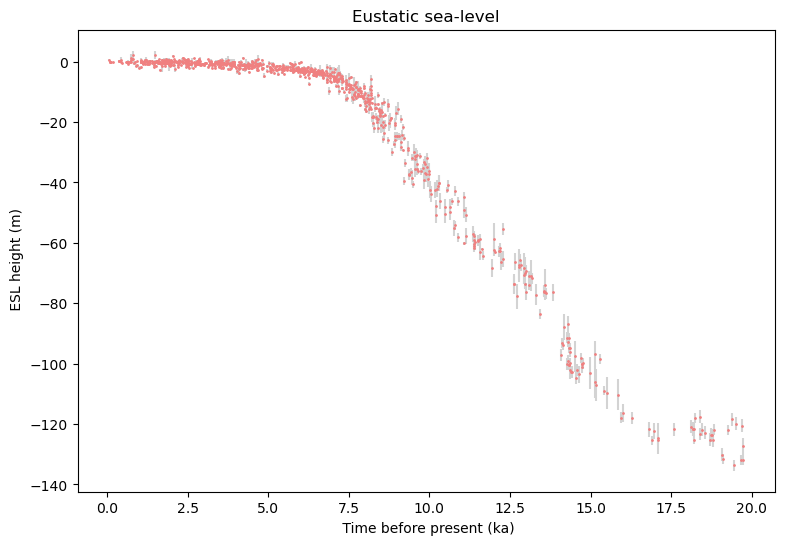

In [8]:
def plot_data(x=data_x,y=data_y,sigma=sy,title=None):
    fig, axes = plt.subplots(figsize=(9,6))
    plt.errorbar(x, y, yerr=sy, fmt='.',color="lightcoral",ecolor='lightgrey',ms=2)
    plt.xlabel(' Time before present (ka)')
    plt.ylabel(' ESL height (m)')
    if(title != None): plt.title(title)
plot_data(title='Eustatic sea-level')

## Problem description

To begin with, we will work with polynomial curves, $$y(x) = \sum_{j=0}^M m_j x^j\,.$$
Here, $M$ is the 'order' of the polynomial: if $M=1$ we have a straight line with 2 parameters, if $M=2$ it will be a quadratic with 3 parameters, and so on. The $m_j, (j=0,\dots M)$ are the 'model coefficients' that we seek to constrain from the data.

For this class of problem the forward operator takes the following form:

$$ \left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$


This clearly has the required general form, $\mathbf{d} =G{\mathbf m}$.

where:

- $\textbf{d}$ is the vector of data values, ($y_0,y_1,\dots,y_N$);
- $\textbf{m}$ is the vector of model parameters, ($m_0,m_1,m_2$);
- $G$ is the basis matrix (or design matrix) of this linear regression problem (also called the ***Jacobian*** matrix for this linear problem).



We have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The function that generated our data is assumed to have independent Gaussian random noise, ${\cal N}(0,\Sigma)$, with $(\Sigma)_{ij} = \delta_{ij}/\sigma_i^2$, where the variance of the noise on each datum, $\sigma_i^2 (i=1,\dots,N)$, differs between observations and is given.

We now build the Jacobian/G matrix for this problem and define a forward function which simply multiplies $\mathbf m$ by $G$.

In [9]:
nparams = 5 # Number of model parameters to be solved for

def jacobian(x=data_x, n=nparams):
    return np.array([x**i for i in range(n)]).T

def forward(model):
    return jacobian().dot(model)

def Cd_inv(sigma=sy):
    factor= 10                                   # factor to inflate observational errors
    return np.diag(1./sy*1./sy)/(factor**2)

Define a reference model for later.

In [10]:
# Reference model for plotting
ESLref = load_data_ref("ESL-f11_yonly.txt") # Load x, y, z reference model and estimated derivative (x=time, Y=ESL, z=dESL/dt) 
ndata2 = np.where(ESLref.T[0]>maxtime)[0][0]
ESLref = ESLref[:ndata2]
ref_x,ref_y = ESLref.T[0],ESLref.T[1]

Now lets plot the data with the reference curve

In [11]:
# Some plotting utilities
def plot_model(x,y, label, color=None,lw=0.5):
    plt.plot(x, y, color=color or "green", label=label,lw=lw)
    #plt.xlabel("X")
    #plt.ylabel("ESL")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1,lw=0.5):
    G = jacobian(data_x)
    plt.plot(data_x, G.dot(models[0]), color=color, label=label, alpha=alpha,lw=lw)
    for m in models:
        plt.plot(data_x, G.dot(m), color=color, alpha=alpha,lw=lw)
    plt.legend()

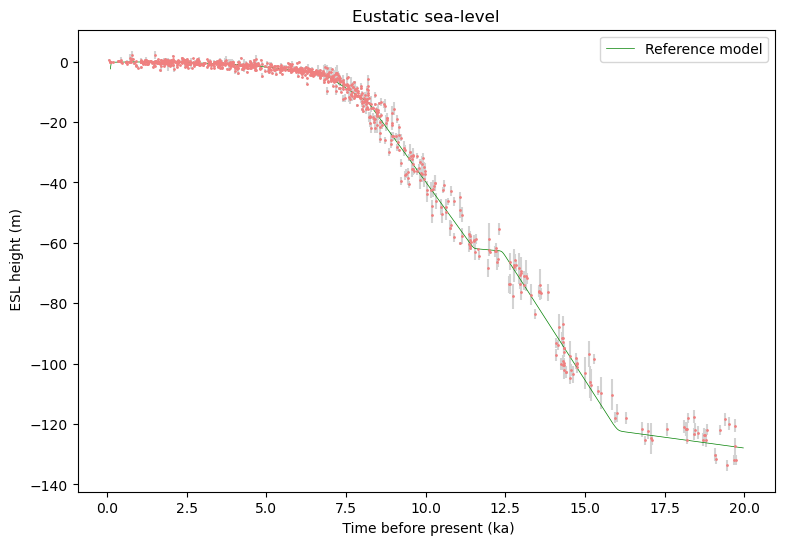

In [12]:
plot_data(title="Eustatic sea-level")
plot_model(ref_x,ref_y, "Reference model")

Now we have the data and the forward model we can start to try and estimate the coefficients of the polynomial from the data.

## The structure of CoFI <a name="CoFI-structure"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines the inverse problem including any user supplied quantities such as data vector, number of model parameters and measure of fit between model predictions and data. 
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_jacobian(some_function_here)
    inv_problem.set_initial_model(a_starting_point) # if needed, e.g. we are solving a nonlinear problem by optimization
    ```
    
    &nbsp; 
- `InversionOptions` describes details about how one wants to run the inversion, including the backend tool and solver-specific parameters. It is based on the concept of a `method` and `tool`.

    ```python
    inv_options = InversionOptions()
    inv_options.suggest_solving_methods()
    inv_options.set_solving_method("matrix solvers")
    inv_options.suggest_tools()
    inv_options.set_tool("scipy.linalg.lstsq")
    inv_options.summary()
    ```

    &nbsp; 
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
    ```python
    inv = Inversion(inv_problem, inv_options)
    result = inv.run()
    ```
 
 Internally CoFI decides the nature of the problem from the quantities set by the user and performs internal checks to ensure it has all that it needs to solve a problem.

## 1. Linear system solver

In [13]:
from cofi import BaseProblem, InversionOptions, Inversion

### Step 1. Define CoFI `BaseProblem`

In [14]:
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian())
inv_problem.set_data_covariance_inv(Cd_inv())

### Step 2. Define CoFI `InversionOptions`

In [15]:
inv_options = InversionOptions()

Using the information supplied, we can ask CoFI to suggest some solving methods.

In [16]:
inv_options.suggest_solving_methods()

The following solving methods are supported:
{'optimization', 'matrix solvers', 'sampling'}

Use `suggest_tools()` to see a full list of backend tools for each method


We can ask CoFI to suggest some specific software tools as well. 

In [17]:
inv_options.suggest_tools()

Here's a complete list of inversion tools supported by CoFI (grouped by methods):
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim"
    ],
    "matrix solvers": [
        "scipy.linalg.lstsq",
        "cofi.simple_newton"
    ],
    "sampling": [
        "emcee"
    ]
}


In [18]:
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.linalg.lstsq (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [19]:
# below is optional, as this has already been the default tool under "linear least square"
inv_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

Our choices so far have defined a linear parameter estimation problem (without any regularization) to be solved within a least squares framework. In this case 
the selection of a `matrix solvers` method will mean we are calculating the standard least squares solution 

$$
m = (G^T C_d^{-1} G)^{-1} G^T C_d^{-1} d
$$

and our choice of backend tool `scipy.linalg.lstsq`, means that we will employ scipy's `linalg` package to perform the numerics.

Lets run CoFI.

In [20]:
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

In [21]:
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]

Summary for inversion result
SUCCESS
----------------------------
model: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]
sum_of_squared_residuals: []
effective_rank: 5
singular_values: [1.72339368e+09 1.35569994e+06 3.54123758e+03 1.10384400e+02
 7.16903392e+00]
model_covariance: [[ 6.70145209e-02 -6.28173834e-02  1.67266578e-02 -1.60867740e-03
   4.77025592e-05]
 [-6.28173834e-02  7.43365995e-02 -2.23488563e-02  2.32179303e-03
  -7.20214235e-05]
 [ 1.67266578e-02 -2.23488563e-02  7.38371078e-03 -8.20763652e-04
   2.65025504e-05]
 [-1.60867740e-03  2.32179303e-03 -8.20763652e-04  9.62437921e-05
  -3.21300646e-06]
 [ 4.77025592e-05 -7.20214235e-05  2.65025504e-05 -3.21300646e-06
   1.10114955e-07]]


Lets plot the solution.

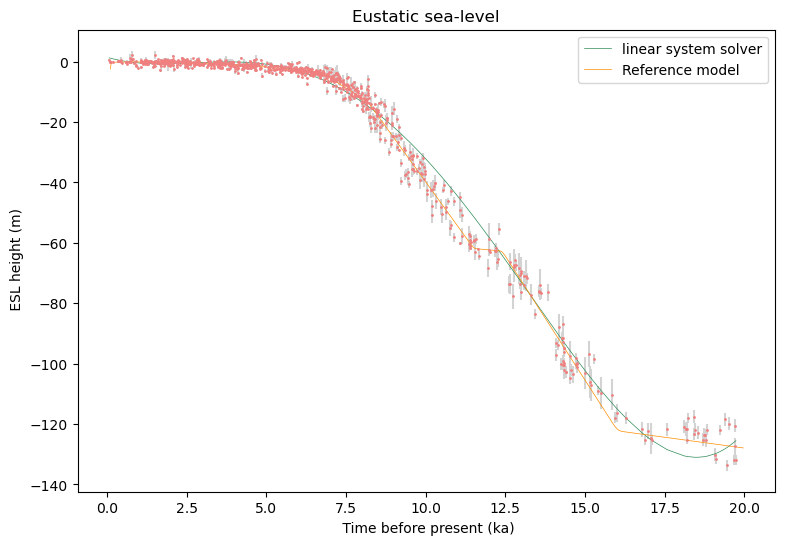

In [22]:
plot_data(title="Eustatic sea-level")
plot_model(data_x,jacobian(data_x).dot(inv_result.model), "linear system solver", color="seagreen")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

## 2. Optimizer

The same overdetermined linear problem, $\textbf{d} = G\textbf{m}$, with Gaussian data noise can also be solved by minimising the squares of the 
residual of the linear equations, e.g. $\textbf{r}^T \textbf{C}_d^{-1}\textbf{r}$ where 
$\textbf{r}=\textbf{d}-G\textbf{m}$. The above matrix solver solution gives us the best data fitting model, but a direct optimisation approach could also be used, say when the number of unknowns is large and we do not wish, or are unable to provide the Jacobian function.

So we use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

<!-- For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with 
CoFI. In the example below we provide functions to calculate the data and the optional 
regularisation. CoFI then generates the objective function for us based on the information 
provided. The alternative to this would be to directly provide objective function to CoFI. -->

In [23]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_initial_model(np.ones(nparams))
#inv_problem.set_initial_model(inv_result.model)
inv_problem.set_forward(forward)
inv_problem.set_data_misfit("squared error")

# inv_problem.set_objective(your_own_misfit_function)    # (optionally) if you'd like to define your own misfit
# inv_problem.set_gradient(your_own_gradient_of_misfit_function)    # (optionally) if you'd like to define your own misfit gradient

######## CoFI InversionOptions - set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")
inv_options_2.set_params(method="Nelder-Mead")

######## CoFI Inversion - run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]

Summary for inversion result
FAILURE
----------------------------
fun: 396.30180936007037
nit: 598
nfev: 1000
status: 1
message: Maximum number of function evaluations has been exceeded.
final_simplex: (array([[ 4.02211771, -7.6352002 ,  3.47983694, -0.52237961,  0.02043681],
       [ 4.02227491, -7.63498804,  3.47977907, -0.52238912,  0.02043829],
       [ 4.02218792, -7.63507241,  3.47979137, -0.5223722 ,  0.02043577],
       [ 4.02245903, -7.63488993,  3.47966829, -0.52235893,  0.02043602],
       [ 4.02257488, -7.63525136,  3.47962954, -0.52233062,  0.02043424],
       [ 4.02215782, -7.63502984,  3.47981924, -0.5223883 ,  0.02043736]]), array([396.30180936, 396.30181593, 396.30181983, 396.30182837,
       396.30183836, 396.30184074]))
model: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]


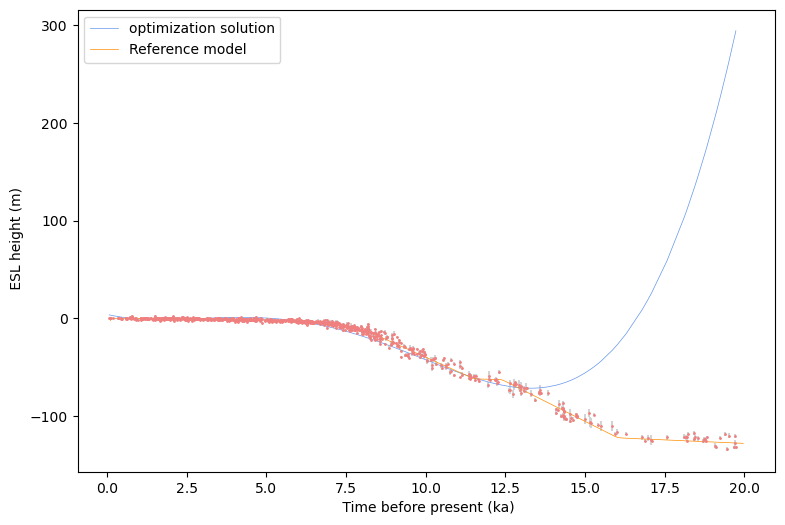

In [24]:
plot_data()
plot_model(data_x,jacobian(data_x).dot(inv_result_2.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

The optimization fails to convergence for this problem (with default settings). 

-------

### Challenge - Change the polynomial degree

Try and replace the 3rd order polynomial with a 2nd order polynomial (i.e. $M=2$) by adding the required commands below. What does the plot looks like? 

Start from code below:

```
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=<CHANGE ME>))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = <CHANGE ME> ")
plot_data()
plot_model(data_x,jacobian(x,n=<CHANGE ME>).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

```


In [25]:
# Copy the template above, Replace <CHANGE ME> with your answer



Inferred curve with n = 3 


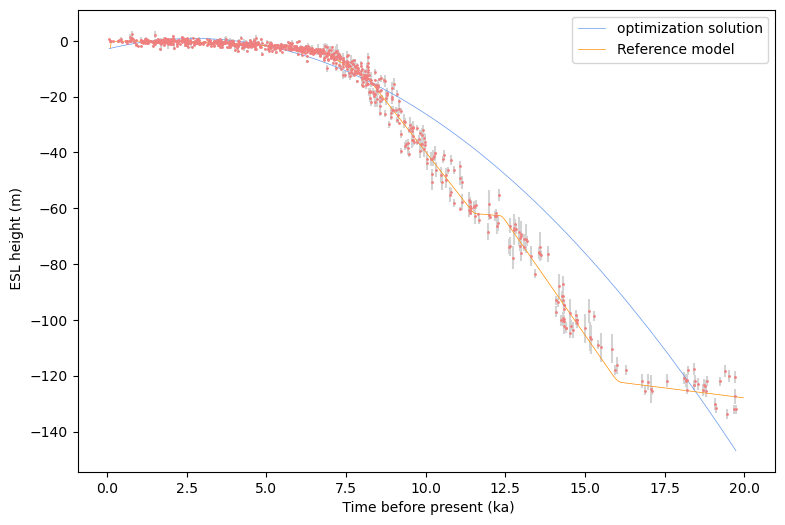

In [26]:
#@title Solution

inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=3))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = 3 ")
plot_data()
plot_model(data_x,jacobian(data_x,n=3).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

Changing to a second order polynomial does converge but gives a poor fit.

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$. 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

Here we artificially increase the observational errors on the data so that the spread of the posterior samples are visible.

In [27]:
Cdinv = Cd_inv()                 # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

Note that the user could specify **any appropriate Likelihood function** of their choosing here.

### Prior

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [28]:
m_lower_bound = np.ones(nparams) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(nparams) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m})p(\mathbf{m})$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d})$ over model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

### Starting points for random walkers

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [29]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

### Add the information and run with CoFI

In [30]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

######## CoFI InversionOptions - get a different tool
inv_options_3 = InversionOptions()
inv_options_3.set_tool("emcee")      # Here we use to Affine Invariant McMC sampler from Goodman and Weare (2010).
inv_options_3.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True, initial_state=walkers_start)

######## CoFI Inversion - run it
inv_3 = Inversion(inv_problem, inv_options_3)
inv_result_3 = inv_3.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `emcee`:")
inv_result_3.summary()

  0%|                                                                                                                                                       | 0/10000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                            | 14/10000 [00:00<01:14, 133.85it/s]

  0%|▍                                                                                                                                            | 28/10000 [00:00<01:14, 133.83it/s]

  0%|▌                                                                                                                                            | 42/10000 [00:00<01:13, 135.91it/s]

  1%|▊                                                                                                                                            | 56/10000 [00:00<01:12, 137.42it/s]

  1%|▉                                                                                                                                            | 70/10000 [00:00<01:12, 136.55it/s]

  1%|█▏                                                                                                                                           | 84/10000 [00:00<01:12, 136.84it/s]

  1%|█▍                                                                                                                                           | 98/10000 [00:00<01:11, 137.55it/s]

  1%|█▌                                                                                                                                          | 112/10000 [00:00<01:11, 138.07it/s]

  1%|█▊                                                                                                                                          | 126/10000 [00:00<01:11, 138.64it/s]

  1%|█▉                                                                                                                                          | 140/10000 [00:01<01:10, 138.89it/s]

  2%|██▏                                                                                                                                         | 154/10000 [00:01<01:11, 137.87it/s]

  2%|██▎                                                                                                                                         | 168/10000 [00:01<01:12, 136.19it/s]

  2%|██▌                                                                                                                                         | 182/10000 [00:01<01:11, 137.15it/s]

  2%|██▋                                                                                                                                         | 196/10000 [00:01<01:11, 137.77it/s]

  2%|██▉                                                                                                                                         | 211/10000 [00:01<01:10, 138.53it/s]

  2%|███▏                                                                                                                                        | 225/10000 [00:01<01:10, 138.84it/s]

  2%|███▎                                                                                                                                        | 239/10000 [00:01<01:10, 139.07it/s]

  3%|███▌                                                                                                                                        | 253/10000 [00:01<01:10, 139.16it/s]

  3%|███▋                                                                                                                                        | 267/10000 [00:01<01:09, 139.38it/s]

  3%|███▉                                                                                                                                        | 281/10000 [00:02<01:09, 139.49it/s]

  3%|████▏                                                                                                                                       | 295/10000 [00:02<01:10, 137.58it/s]

  3%|████▎                                                                                                                                       | 309/10000 [00:02<01:10, 138.30it/s]

  3%|████▌                                                                                                                                       | 324/10000 [00:02<01:09, 138.86it/s]

  3%|████▋                                                                                                                                       | 338/10000 [00:02<01:09, 139.12it/s]

  4%|████▉                                                                                                                                       | 353/10000 [00:02<01:09, 139.41it/s]

  4%|█████▏                                                                                                                                      | 367/10000 [00:02<01:09, 139.40it/s]

  4%|█████▎                                                                                                                                      | 382/10000 [00:02<01:08, 139.61it/s]

  4%|█████▌                                                                                                                                      | 397/10000 [00:02<01:08, 139.81it/s]

  4%|█████▊                                                                                                                                      | 411/10000 [00:02<01:08, 139.86it/s]

  4%|█████▉                                                                                                                                      | 426/10000 [00:03<01:08, 139.93it/s]

  4%|██████▏                                                                                                                                     | 441/10000 [00:03<01:08, 140.10it/s]

  5%|██████▍                                                                                                                                     | 456/10000 [00:03<01:14, 128.67it/s]

  5%|██████▌                                                                                                                                     | 470/10000 [00:03<01:14, 127.96it/s]

  5%|██████▊                                                                                                                                     | 483/10000 [00:03<01:14, 127.13it/s]

  5%|██████▉                                                                                                                                     | 497/10000 [00:03<01:13, 129.58it/s]

  5%|███████▏                                                                                                                                    | 511/10000 [00:03<01:11, 131.87it/s]

  5%|███████▎                                                                                                                                    | 525/10000 [00:03<01:11, 133.36it/s]

  5%|███████▌                                                                                                                                    | 540/10000 [00:03<01:09, 135.41it/s]

  6%|███████▊                                                                                                                                    | 554/10000 [00:04<01:09, 135.80it/s]

  6%|███████▉                                                                                                                                    | 568/10000 [00:04<01:17, 121.92it/s]

  6%|████████▏                                                                                                                                   | 582/10000 [00:04<01:14, 126.67it/s]

  6%|████████▎                                                                                                                                   | 596/10000 [00:04<01:13, 128.30it/s]

  6%|████████▌                                                                                                                                   | 610/10000 [00:04<01:11, 131.35it/s]

  6%|████████▋                                                                                                                                   | 624/10000 [00:04<01:10, 133.50it/s]

  6%|████████▉                                                                                                                                   | 638/10000 [00:04<01:09, 135.22it/s]

  7%|█████████▏                                                                                                                                  | 652/10000 [00:04<01:08, 136.55it/s]

  7%|█████████▎                                                                                                                                  | 666/10000 [00:04<01:07, 137.36it/s]

  7%|█████████▌                                                                                                                                  | 680/10000 [00:05<01:07, 138.04it/s]

  7%|█████████▋                                                                                                                                  | 694/10000 [00:05<01:08, 136.68it/s]

  7%|█████████▉                                                                                                                                  | 708/10000 [00:05<01:07, 136.78it/s]

  7%|██████████                                                                                                                                  | 722/10000 [00:05<01:12, 128.32it/s]

  7%|██████████▎                                                                                                                                 | 736/10000 [00:05<01:10, 131.61it/s]

  8%|██████████▌                                                                                                                                 | 750/10000 [00:05<01:09, 132.35it/s]

  8%|██████████▋                                                                                                                                 | 764/10000 [00:05<01:08, 134.01it/s]

  8%|██████████▉                                                                                                                                 | 778/10000 [00:05<01:08, 135.58it/s]

  8%|███████████                                                                                                                                 | 792/10000 [00:05<01:07, 136.68it/s]

  8%|███████████▎                                                                                                                                | 806/10000 [00:05<01:06, 137.42it/s]

  8%|███████████▍                                                                                                                                | 820/10000 [00:06<01:06, 137.95it/s]

  8%|███████████▋                                                                                                                                | 834/10000 [00:06<01:06, 138.33it/s]

  8%|███████████▊                                                                                                                                | 848/10000 [00:06<01:06, 137.62it/s]

  9%|████████████                                                                                                                                | 862/10000 [00:06<01:06, 138.23it/s]

  9%|████████████▎                                                                                                                               | 876/10000 [00:06<01:05, 138.66it/s]

  9%|████████████▍                                                                                                                               | 890/10000 [00:06<01:06, 137.88it/s]

  9%|████████████▋                                                                                                                               | 904/10000 [00:06<01:06, 137.25it/s]

  9%|████████████▊                                                                                                                               | 918/10000 [00:06<01:06, 137.50it/s]

  9%|█████████████                                                                                                                               | 932/10000 [00:06<01:05, 138.13it/s]

  9%|█████████████▏                                                                                                                              | 946/10000 [00:06<01:05, 138.44it/s]

 10%|█████████████▍                                                                                                                              | 960/10000 [00:07<01:05, 138.74it/s]

 10%|█████████████▋                                                                                                                              | 974/10000 [00:07<01:07, 134.47it/s]

 10%|█████████████▊                                                                                                                              | 988/10000 [00:07<01:06, 135.93it/s]

 10%|█████████████▉                                                                                                                             | 1002/10000 [00:07<01:05, 136.96it/s]

 10%|██████████████                                                                                                                             | 1016/10000 [00:07<01:05, 137.81it/s]

 10%|██████████████▎                                                                                                                            | 1030/10000 [00:07<01:05, 137.42it/s]

 10%|██████████████▌                                                                                                                            | 1044/10000 [00:07<01:04, 137.80it/s]

 11%|██████████████▋                                                                                                                            | 1058/10000 [00:07<01:04, 138.04it/s]

 11%|██████████████▉                                                                                                                            | 1072/10000 [00:07<01:04, 138.55it/s]

 11%|███████████████                                                                                                                            | 1086/10000 [00:07<01:04, 138.81it/s]

 11%|███████████████▎                                                                                                                           | 1100/10000 [00:08<01:04, 137.22it/s]

 11%|███████████████▍                                                                                                                           | 1114/10000 [00:08<01:04, 137.96it/s]

 11%|███████████████▋                                                                                                                           | 1128/10000 [00:08<01:04, 138.55it/s]

 11%|███████████████▊                                                                                                                           | 1142/10000 [00:08<01:03, 138.85it/s]

 12%|████████████████                                                                                                                           | 1156/10000 [00:08<01:03, 139.19it/s]

 12%|████████████████▎                                                                                                                          | 1170/10000 [00:08<01:03, 139.39it/s]

 12%|████████████████▍                                                                                                                          | 1184/10000 [00:08<01:03, 139.51it/s]

 12%|████████████████▋                                                                                                                          | 1198/10000 [00:08<01:03, 139.58it/s]

 12%|████████████████▊                                                                                                                          | 1212/10000 [00:08<01:02, 139.69it/s]

 12%|█████████████████                                                                                                                          | 1226/10000 [00:08<01:02, 139.76it/s]

 12%|█████████████████▏                                                                                                                         | 1240/10000 [00:09<01:02, 139.48it/s]

 13%|█████████████████▍                                                                                                                         | 1254/10000 [00:09<01:02, 139.61it/s]

 13%|█████████████████▋                                                                                                                         | 1268/10000 [00:09<01:02, 139.71it/s]

 13%|█████████████████▊                                                                                                                         | 1282/10000 [00:09<01:02, 139.80it/s]

 13%|██████████████████                                                                                                                         | 1296/10000 [00:09<01:02, 139.75it/s]

 13%|██████████████████▏                                                                                                                        | 1310/10000 [00:09<01:02, 139.81it/s]

 13%|██████████████████▍                                                                                                                        | 1324/10000 [00:09<01:03, 136.47it/s]

 13%|██████████████████▌                                                                                                                        | 1338/10000 [00:09<01:03, 136.53it/s]

 14%|██████████████████▊                                                                                                                        | 1352/10000 [00:09<01:02, 137.28it/s]

 14%|███████████████████                                                                                                                        | 1367/10000 [00:10<01:02, 138.06it/s]

 14%|███████████████████▏                                                                                                                       | 1382/10000 [00:10<01:02, 138.76it/s]

 14%|███████████████████▍                                                                                                                       | 1396/10000 [00:10<01:02, 138.38it/s]

 14%|███████████████████▌                                                                                                                       | 1411/10000 [00:10<01:01, 139.03it/s]

 14%|███████████████████▊                                                                                                                       | 1426/10000 [00:10<01:01, 139.48it/s]

 14%|████████████████████                                                                                                                       | 1441/10000 [00:10<01:01, 139.70it/s]

 15%|████████████████████▏                                                                                                                      | 1456/10000 [00:10<01:01, 139.90it/s]

 15%|████████████████████▍                                                                                                                      | 1470/10000 [00:10<01:00, 139.89it/s]

 15%|████████████████████▋                                                                                                                      | 1485/10000 [00:10<01:00, 139.98it/s]

 15%|████████████████████▊                                                                                                                      | 1500/10000 [00:10<01:00, 140.06it/s]

 15%|█████████████████████                                                                                                                      | 1515/10000 [00:11<01:02, 136.23it/s]

 15%|█████████████████████▎                                                                                                                     | 1530/10000 [00:11<01:01, 137.44it/s]

 15%|█████████████████████▍                                                                                                                     | 1544/10000 [00:11<01:02, 134.70it/s]

 16%|█████████████████████▋                                                                                                                     | 1559/10000 [00:11<01:01, 136.33it/s]

 16%|█████████████████████▊                                                                                                                     | 1573/10000 [00:11<01:02, 134.05it/s]

 16%|██████████████████████                                                                                                                     | 1587/10000 [00:11<01:01, 135.73it/s]

 16%|██████████████████████▎                                                                                                                    | 1602/10000 [00:11<01:01, 137.07it/s]

 16%|██████████████████████▍                                                                                                                    | 1616/10000 [00:11<01:01, 136.66it/s]

 16%|██████████████████████▋                                                                                                                    | 1631/10000 [00:11<01:00, 137.76it/s]

 16%|██████████████████████▊                                                                                                                    | 1645/10000 [00:12<01:01, 134.91it/s]

 17%|███████████████████████                                                                                                                    | 1659/10000 [00:12<01:01, 135.89it/s]

 17%|███████████████████████▎                                                                                                                   | 1674/10000 [00:12<01:00, 137.22it/s]

 17%|███████████████████████▍                                                                                                                   | 1688/10000 [00:12<01:00, 137.59it/s]

 17%|███████████████████████▋                                                                                                                   | 1702/10000 [00:12<01:00, 138.28it/s]

 17%|███████████████████████▊                                                                                                                   | 1716/10000 [00:12<00:59, 138.71it/s]

 17%|████████████████████████                                                                                                                   | 1730/10000 [00:12<00:59, 139.04it/s]

 17%|████████████████████████▎                                                                                                                  | 1745/10000 [00:12<00:59, 138.61it/s]

 18%|████████████████████████▍                                                                                                                  | 1760/10000 [00:12<00:59, 139.15it/s]

 18%|████████████████████████▋                                                                                                                  | 1774/10000 [00:12<00:59, 139.10it/s]

 18%|████████████████████████▊                                                                                                                  | 1789/10000 [00:13<00:58, 139.48it/s]

 18%|█████████████████████████                                                                                                                  | 1803/10000 [00:13<00:58, 139.58it/s]

 18%|█████████████████████████▎                                                                                                                 | 1817/10000 [00:13<00:58, 139.69it/s]

 18%|█████████████████████████▍                                                                                                                 | 1832/10000 [00:13<00:58, 139.89it/s]

 18%|█████████████████████████▋                                                                                                                 | 1846/10000 [00:13<00:58, 139.86it/s]

 19%|█████████████████████████▊                                                                                                                 | 1860/10000 [00:13<00:58, 139.80it/s]

 19%|██████████████████████████                                                                                                                 | 1875/10000 [00:13<00:58, 140.05it/s]

 19%|██████████████████████████▎                                                                                                                | 1890/10000 [00:13<00:57, 140.09it/s]

 19%|██████████████████████████▍                                                                                                                | 1905/10000 [00:13<00:57, 140.24it/s]

 19%|██████████████████████████▋                                                                                                                | 1920/10000 [00:14<01:08, 118.43it/s]

 19%|██████████████████████████▉                                                                                                                | 1934/10000 [00:14<01:05, 123.75it/s]

 19%|███████████████████████████                                                                                                                | 1949/10000 [00:14<01:02, 128.37it/s]

 20%|███████████████████████████▎                                                                                                               | 1963/10000 [00:14<01:01, 131.49it/s]

 20%|███████████████████████████▍                                                                                                               | 1977/10000 [00:14<00:59, 133.86it/s]

 20%|███████████████████████████▋                                                                                                               | 1991/10000 [00:14<00:59, 135.49it/s]

 20%|███████████████████████████▊                                                                                                               | 2005/10000 [00:14<00:58, 135.91it/s]

 20%|████████████████████████████                                                                                                               | 2019/10000 [00:14<00:58, 136.22it/s]

 20%|████████████████████████████▎                                                                                                              | 2033/10000 [00:14<00:58, 137.30it/s]

 20%|████████████████████████████▍                                                                                                              | 2047/10000 [00:14<00:57, 138.05it/s]

 21%|████████████████████████████▋                                                                                                              | 2061/10000 [00:15<00:59, 134.37it/s]

 21%|████████████████████████████▊                                                                                                              | 2076/10000 [00:15<00:58, 136.25it/s]

 21%|█████████████████████████████                                                                                                              | 2090/10000 [00:15<00:57, 136.63it/s]

 21%|█████████████████████████████▎                                                                                                             | 2105/10000 [00:15<00:57, 137.72it/s]

 21%|█████████████████████████████▍                                                                                                             | 2120/10000 [00:15<00:56, 138.62it/s]

 21%|█████████████████████████████▋                                                                                                             | 2135/10000 [00:15<00:56, 139.20it/s]

 21%|█████████████████████████████▊                                                                                                             | 2149/10000 [00:15<00:56, 139.27it/s]

 22%|██████████████████████████████                                                                                                             | 2163/10000 [00:15<00:56, 139.45it/s]

 22%|██████████████████████████████▎                                                                                                            | 2178/10000 [00:15<00:56, 139.65it/s]

 22%|██████████████████████████████▍                                                                                                            | 2192/10000 [00:16<00:55, 139.56it/s]

 22%|██████████████████████████████▋                                                                                                            | 2206/10000 [00:16<00:55, 139.65it/s]

 22%|██████████████████████████████▊                                                                                                            | 2220/10000 [00:16<00:55, 139.75it/s]

 22%|███████████████████████████████                                                                                                            | 2235/10000 [00:16<00:55, 139.96it/s]

 22%|███████████████████████████████▎                                                                                                           | 2249/10000 [00:16<00:59, 129.22it/s]

 23%|███████████████████████████████▍                                                                                                           | 2263/10000 [00:16<00:58, 132.12it/s]

 23%|███████████████████████████████▋                                                                                                           | 2277/10000 [00:16<00:57, 133.24it/s]

 23%|███████████████████████████████▊                                                                                                           | 2291/10000 [00:16<00:58, 132.11it/s]

 23%|████████████████████████████████                                                                                                           | 2305/10000 [00:16<00:57, 132.74it/s]

 23%|████████████████████████████████▏                                                                                                          | 2320/10000 [00:16<00:56, 135.00it/s]

 23%|████████████████████████████████▍                                                                                                          | 2334/10000 [00:17<00:56, 134.92it/s]

 23%|████████████████████████████████▋                                                                                                          | 2348/10000 [00:17<00:57, 133.89it/s]

 24%|████████████████████████████████▊                                                                                                          | 2363/10000 [00:17<00:56, 136.04it/s]

 24%|█████████████████████████████████                                                                                                          | 2378/10000 [00:17<00:55, 137.47it/s]

 24%|█████████████████████████████████▎                                                                                                         | 2393/10000 [00:17<00:54, 138.48it/s]

 24%|█████████████████████████████████▍                                                                                                         | 2408/10000 [00:17<00:54, 139.27it/s]

 24%|█████████████████████████████████▋                                                                                                         | 2423/10000 [00:17<00:54, 139.73it/s]

 24%|█████████████████████████████████▉                                                                                                         | 2438/10000 [00:17<00:54, 139.99it/s]

 25%|██████████████████████████████████                                                                                                         | 2453/10000 [00:17<00:53, 140.10it/s]

 25%|██████████████████████████████████▎                                                                                                        | 2468/10000 [00:18<00:53, 140.36it/s]

 25%|██████████████████████████████████▌                                                                                                        | 2483/10000 [00:18<00:53, 140.54it/s]

 25%|██████████████████████████████████▋                                                                                                        | 2498/10000 [00:18<00:53, 140.69it/s]

 25%|██████████████████████████████████▉                                                                                                        | 2513/10000 [00:18<00:53, 140.68it/s]

 25%|███████████████████████████████████▏                                                                                                       | 2528/10000 [00:18<00:53, 140.73it/s]

 25%|███████████████████████████████████▎                                                                                                       | 2543/10000 [00:18<00:52, 140.76it/s]

 26%|███████████████████████████████████▌                                                                                                       | 2558/10000 [00:18<00:52, 140.75it/s]

 26%|███████████████████████████████████▊                                                                                                       | 2573/10000 [00:18<00:52, 140.86it/s]

 26%|███████████████████████████████████▉                                                                                                       | 2588/10000 [00:18<00:52, 140.94it/s]

 26%|████████████████████████████████████▏                                                                                                      | 2603/10000 [00:18<00:52, 140.75it/s]

 26%|████████████████████████████████████▍                                                                                                      | 2618/10000 [00:19<00:52, 140.69it/s]

 26%|████████████████████████████████████▌                                                                                                      | 2633/10000 [00:19<00:52, 140.45it/s]

 26%|████████████████████████████████████▊                                                                                                      | 2648/10000 [00:19<00:52, 140.54it/s]

 27%|█████████████████████████████████████                                                                                                      | 2663/10000 [00:19<00:52, 140.71it/s]

 27%|█████████████████████████████████████▏                                                                                                     | 2678/10000 [00:19<00:52, 140.80it/s]

 27%|█████████████████████████████████████▍                                                                                                     | 2693/10000 [00:19<00:51, 140.61it/s]

 27%|█████████████████████████████████████▋                                                                                                     | 2708/10000 [00:19<00:51, 140.78it/s]

 27%|█████████████████████████████████████▊                                                                                                     | 2723/10000 [00:19<00:51, 140.71it/s]

 27%|██████████████████████████████████████                                                                                                     | 2738/10000 [00:19<00:51, 140.45it/s]

 28%|██████████████████████████████████████▎                                                                                                    | 2753/10000 [00:20<00:52, 138.75it/s]

 28%|██████████████████████████████████████▍                                                                                                    | 2768/10000 [00:20<00:51, 139.31it/s]

 28%|██████████████████████████████████████▋                                                                                                    | 2782/10000 [00:20<00:51, 138.82it/s]

 28%|██████████████████████████████████████▊                                                                                                    | 2796/10000 [00:20<00:52, 138.16it/s]

 28%|███████████████████████████████████████                                                                                                    | 2810/10000 [00:20<00:51, 138.45it/s]

 28%|███████████████████████████████████████▎                                                                                                   | 2824/10000 [00:20<00:52, 136.30it/s]

 28%|███████████████████████████████████████▍                                                                                                   | 2838/10000 [00:20<00:52, 137.33it/s]

 29%|███████████████████████████████████████▋                                                                                                   | 2852/10000 [00:20<00:51, 137.93it/s]

 29%|███████████████████████████████████████▊                                                                                                   | 2866/10000 [00:20<00:51, 138.00it/s]

 29%|████████████████████████████████████████                                                                                                   | 2880/10000 [00:20<00:51, 138.50it/s]

 29%|████████████████████████████████████████▏                                                                                                  | 2894/10000 [00:21<00:51, 138.80it/s]

 29%|████████████████████████████████████████▍                                                                                                  | 2909/10000 [00:21<00:50, 139.21it/s]

 29%|████████████████████████████████████████▋                                                                                                  | 2923/10000 [00:21<00:50, 139.36it/s]

 29%|████████████████████████████████████████▊                                                                                                  | 2937/10000 [00:21<00:50, 139.46it/s]

 30%|█████████████████████████████████████████                                                                                                  | 2951/10000 [00:21<00:50, 139.14it/s]

 30%|█████████████████████████████████████████▏                                                                                                 | 2966/10000 [00:21<00:50, 139.45it/s]

 30%|█████████████████████████████████████████▍                                                                                                 | 2980/10000 [00:21<00:50, 139.51it/s]

 30%|█████████████████████████████████████████▌                                                                                                 | 2994/10000 [00:21<00:50, 139.58it/s]

 30%|█████████████████████████████████████████▊                                                                                                 | 3008/10000 [00:21<00:50, 139.54it/s]

 30%|██████████████████████████████████████████                                                                                                 | 3022/10000 [00:22<00:50, 139.53it/s]

 30%|██████████████████████████████████████████▏                                                                                                | 3036/10000 [00:22<00:49, 139.61it/s]

 30%|██████████████████████████████████████████▍                                                                                                | 3050/10000 [00:22<00:49, 139.68it/s]

 31%|██████████████████████████████████████████▌                                                                                                | 3064/10000 [00:22<00:49, 139.74it/s]

 31%|██████████████████████████████████████████▊                                                                                                | 3078/10000 [00:22<00:49, 139.79it/s]

 31%|██████████████████████████████████████████▉                                                                                                | 3093/10000 [00:22<00:49, 139.91it/s]

 31%|███████████████████████████████████████████▏                                                                                               | 3107/10000 [00:22<00:49, 139.85it/s]

 31%|███████████████████████████████████████████▍                                                                                               | 3121/10000 [00:22<00:49, 139.43it/s]

 31%|███████████████████████████████████████████▌                                                                                               | 3135/10000 [00:22<00:49, 139.56it/s]

 31%|███████████████████████████████████████████▊                                                                                               | 3149/10000 [00:22<00:50, 136.66it/s]

 32%|███████████████████████████████████████████▉                                                                                               | 3163/10000 [00:23<00:49, 136.93it/s]

 32%|████████████████████████████████████████████▏                                                                                              | 3177/10000 [00:23<00:50, 135.89it/s]

 32%|████████████████████████████████████████████▎                                                                                              | 3191/10000 [00:23<00:49, 136.98it/s]

 32%|████████████████████████████████████████████▌                                                                                              | 3206/10000 [00:23<00:49, 137.97it/s]

 32%|████████████████████████████████████████████▊                                                                                              | 3221/10000 [00:23<00:48, 138.68it/s]

 32%|████████████████████████████████████████████▉                                                                                              | 3235/10000 [00:23<00:48, 138.78it/s]

 32%|█████████████████████████████████████████████▏                                                                                             | 3249/10000 [00:23<00:48, 139.09it/s]

 33%|█████████████████████████████████████████████▎                                                                                             | 3264/10000 [00:23<00:48, 139.52it/s]

 33%|█████████████████████████████████████████████▌                                                                                             | 3279/10000 [00:23<00:48, 139.75it/s]

 33%|█████████████████████████████████████████████▊                                                                                             | 3293/10000 [00:23<00:47, 139.82it/s]

 33%|█████████████████████████████████████████████▉                                                                                             | 3307/10000 [00:24<00:48, 138.30it/s]

 33%|██████████████████████████████████████████████▏                                                                                            | 3321/10000 [00:24<00:48, 138.75it/s]

 33%|██████████████████████████████████████████████▎                                                                                            | 3336/10000 [00:24<00:47, 139.24it/s]

 34%|██████████████████████████████████████████████▌                                                                                            | 3350/10000 [00:24<00:47, 139.45it/s]

 34%|██████████████████████████████████████████████▊                                                                                            | 3365/10000 [00:24<00:47, 139.67it/s]

 34%|██████████████████████████████████████████████▉                                                                                            | 3380/10000 [00:24<00:47, 139.82it/s]

 34%|███████████████████████████████████████████████▏                                                                                           | 3394/10000 [00:24<00:47, 139.87it/s]

 34%|███████████████████████████████████████████████▎                                                                                           | 3408/10000 [00:24<00:47, 139.89it/s]

 34%|███████████████████████████████████████████████▌                                                                                           | 3423/10000 [00:24<00:46, 140.05it/s]

 34%|███████████████████████████████████████████████▊                                                                                           | 3438/10000 [00:24<00:46, 139.97it/s]

 35%|███████████████████████████████████████████████▉                                                                                           | 3452/10000 [00:25<00:46, 139.94it/s]

 35%|████████████████████████████████████████████████▏                                                                                          | 3467/10000 [00:25<00:46, 140.10it/s]

 35%|████████████████████████████████████████████████▍                                                                                          | 3482/10000 [00:25<00:46, 139.32it/s]

 35%|████████████████████████████████████████████████▌                                                                                          | 3496/10000 [00:25<00:46, 139.48it/s]

 35%|████████████████████████████████████████████████▊                                                                                          | 3510/10000 [00:25<00:46, 139.30it/s]

 35%|████████████████████████████████████████████████▉                                                                                          | 3525/10000 [00:25<00:46, 139.57it/s]

 35%|█████████████████████████████████████████████████▏                                                                                         | 3539/10000 [00:25<00:46, 139.62it/s]

 36%|█████████████████████████████████████████████████▍                                                                                         | 3554/10000 [00:25<00:46, 139.91it/s]

 36%|█████████████████████████████████████████████████▌                                                                                         | 3569/10000 [00:25<00:45, 140.15it/s]

 36%|█████████████████████████████████████████████████▊                                                                                         | 3584/10000 [00:26<00:45, 140.12it/s]

 36%|██████████████████████████████████████████████████                                                                                         | 3599/10000 [00:26<00:46, 138.60it/s]

 36%|██████████████████████████████████████████████████▏                                                                                        | 3613/10000 [00:26<00:45, 138.92it/s]

 36%|██████████████████████████████████████████████████▍                                                                                        | 3628/10000 [00:26<00:45, 139.40it/s]

 36%|██████████████████████████████████████████████████▋                                                                                        | 3643/10000 [00:26<00:45, 139.67it/s]

 37%|██████████████████████████████████████████████████▊                                                                                        | 3658/10000 [00:26<00:45, 139.86it/s]

 37%|███████████████████████████████████████████████████                                                                                        | 3672/10000 [00:26<00:45, 138.92it/s]

 37%|███████████████████████████████████████████████████▏                                                                                       | 3687/10000 [00:26<00:45, 139.40it/s]

 37%|███████████████████████████████████████████████████▍                                                                                       | 3702/10000 [00:26<00:45, 139.64it/s]

 37%|███████████████████████████████████████████████████▋                                                                                       | 3717/10000 [00:26<00:44, 139.83it/s]

 37%|███████████████████████████████████████████████████▊                                                                                       | 3732/10000 [00:27<00:44, 139.92it/s]

 37%|████████████████████████████████████████████████████                                                                                       | 3747/10000 [00:27<00:44, 140.02it/s]

 38%|████████████████████████████████████████████████████▎                                                                                      | 3762/10000 [00:27<00:44, 140.08it/s]

 38%|████████████████████████████████████████████████████▌                                                                                      | 3777/10000 [00:27<00:44, 140.14it/s]

 38%|████████████████████████████████████████████████████▋                                                                                      | 3792/10000 [00:27<00:44, 140.22it/s]

 38%|████████████████████████████████████████████████████▉                                                                                      | 3807/10000 [00:27<00:44, 138.83it/s]

 38%|█████████████████████████████████████████████████████                                                                                      | 3821/10000 [00:27<00:44, 138.65it/s]

 38%|█████████████████████████████████████████████████████▎                                                                                     | 3835/10000 [00:27<00:44, 138.70it/s]

 38%|█████████████████████████████████████████████████████▌                                                                                     | 3849/10000 [00:27<00:44, 138.69it/s]

 39%|█████████████████████████████████████████████████████▋                                                                                     | 3863/10000 [00:28<00:44, 138.87it/s]

 39%|█████████████████████████████████████████████████████▉                                                                                     | 3877/10000 [00:28<00:44, 138.92it/s]

 39%|██████████████████████████████████████████████████████                                                                                     | 3891/10000 [00:28<00:43, 139.14it/s]

 39%|██████████████████████████████████████████████████████▎                                                                                    | 3905/10000 [00:28<00:43, 139.33it/s]

 39%|██████████████████████████████████████████████████████▍                                                                                    | 3919/10000 [00:28<00:43, 139.23it/s]

 39%|██████████████████████████████████████████████████████▋                                                                                    | 3933/10000 [00:28<00:43, 139.24it/s]

 39%|██████████████████████████████████████████████████████▉                                                                                    | 3948/10000 [00:28<00:43, 139.59it/s]

 40%|███████████████████████████████████████████████████████                                                                                    | 3963/10000 [00:28<00:43, 139.82it/s]

 40%|███████████████████████████████████████████████████████▎                                                                                   | 3977/10000 [00:28<00:43, 139.86it/s]

 40%|███████████████████████████████████████████████████████▍                                                                                   | 3992/10000 [00:28<00:42, 140.03it/s]

 40%|███████████████████████████████████████████████████████▋                                                                                   | 4007/10000 [00:29<00:43, 138.38it/s]

 40%|███████████████████████████████████████████████████████▉                                                                                   | 4022/10000 [00:29<00:43, 139.00it/s]

 40%|████████████████████████████████████████████████████████                                                                                   | 4037/10000 [00:29<00:42, 139.46it/s]

 41%|████████████████████████████████████████████████████████▎                                                                                  | 4052/10000 [00:29<00:42, 139.73it/s]

 41%|████████████████████████████████████████████████████████▌                                                                                  | 4067/10000 [00:29<00:42, 139.93it/s]

 41%|████████████████████████████████████████████████████████▋                                                                                  | 4082/10000 [00:29<00:42, 140.08it/s]

 41%|████████████████████████████████████████████████████████▉                                                                                  | 4097/10000 [00:29<00:42, 140.05it/s]

 41%|█████████████████████████████████████████████████████████▏                                                                                 | 4112/10000 [00:29<00:42, 140.17it/s]

 41%|█████████████████████████████████████████████████████████▎                                                                                 | 4127/10000 [00:29<00:41, 140.20it/s]

 41%|█████████████████████████████████████████████████████████▌                                                                                 | 4142/10000 [00:30<00:47, 124.32it/s]

 42%|█████████████████████████████████████████████████████████▊                                                                                 | 4156/10000 [00:30<00:45, 128.35it/s]

 42%|█████████████████████████████████████████████████████████▉                                                                                 | 4170/10000 [00:30<00:44, 130.88it/s]

 42%|██████████████████████████████████████████████████████████▏                                                                                | 4184/10000 [00:30<00:43, 133.27it/s]

 42%|██████████████████████████████████████████████████████████▎                                                                                | 4198/10000 [00:30<00:43, 134.88it/s]

 42%|██████████████████████████████████████████████████████████▌                                                                                | 4212/10000 [00:30<00:42, 136.00it/s]

 42%|██████████████████████████████████████████████████████████▋                                                                                | 4226/10000 [00:30<00:42, 136.93it/s]

 42%|██████████████████████████████████████████████████████████▉                                                                                | 4240/10000 [00:30<00:41, 137.51it/s]

 43%|███████████████████████████████████████████████████████████▏                                                                               | 4254/10000 [00:30<00:41, 137.87it/s]

 43%|███████████████████████████████████████████████████████████▎                                                                               | 4268/10000 [00:30<00:41, 138.21it/s]

 43%|███████████████████████████████████████████████████████████▌                                                                               | 4282/10000 [00:31<00:41, 138.43it/s]

 43%|███████████████████████████████████████████████████████████▋                                                                               | 4296/10000 [00:31<00:41, 138.62it/s]

 43%|███████████████████████████████████████████████████████████▉                                                                               | 4310/10000 [00:31<00:41, 138.72it/s]

 43%|████████████████████████████████████████████████████████████                                                                               | 4324/10000 [00:31<00:40, 138.76it/s]

 43%|████████████████████████████████████████████████████████████▎                                                                              | 4338/10000 [00:31<00:40, 138.85it/s]

 44%|████████████████████████████████████████████████████████████▍                                                                              | 4352/10000 [00:31<00:40, 138.94it/s]

 44%|████████████████████████████████████████████████████████████▋                                                                              | 4366/10000 [00:31<00:40, 138.88it/s]

 44%|████████████████████████████████████████████████████████████▉                                                                              | 4380/10000 [00:31<00:40, 138.97it/s]

 44%|█████████████████████████████████████████████████████████████                                                                              | 4394/10000 [00:31<00:40, 139.26it/s]

 44%|█████████████████████████████████████████████████████████████▎                                                                             | 4408/10000 [00:32<00:40, 139.41it/s]

 44%|█████████████████████████████████████████████████████████████▍                                                                             | 4422/10000 [00:32<00:40, 137.66it/s]

 44%|█████████████████████████████████████████████████████████████▋                                                                             | 4436/10000 [00:32<00:40, 137.76it/s]

 45%|█████████████████████████████████████████████████████████████▊                                                                             | 4451/10000 [00:32<00:40, 138.54it/s]

 45%|██████████████████████████████████████████████████████████████                                                                             | 4465/10000 [00:32<00:40, 137.82it/s]

 45%|██████████████████████████████████████████████████████████████▎                                                                            | 4479/10000 [00:32<00:39, 138.23it/s]

 45%|██████████████████████████████████████████████████████████████▍                                                                            | 4494/10000 [00:32<00:39, 138.94it/s]

 45%|██████████████████████████████████████████████████████████████▋                                                                            | 4509/10000 [00:32<00:39, 139.38it/s]

 45%|██████████████████████████████████████████████████████████████▉                                                                            | 4524/10000 [00:32<00:39, 139.75it/s]

 45%|███████████████████████████████████████████████████████████████                                                                            | 4539/10000 [00:32<00:39, 139.96it/s]

 46%|███████████████████████████████████████████████████████████████▎                                                                           | 4554/10000 [00:33<00:38, 140.12it/s]

 46%|███████████████████████████████████████████████████████████████▌                                                                           | 4569/10000 [00:33<00:38, 140.32it/s]

 46%|███████████████████████████████████████████████████████████████▋                                                                           | 4584/10000 [00:33<00:38, 140.27it/s]

 46%|███████████████████████████████████████████████████████████████▉                                                                           | 4599/10000 [00:33<00:38, 140.39it/s]

 46%|████████████████████████████████████████████████████████████████▏                                                                          | 4614/10000 [00:33<00:38, 140.41it/s]

 46%|████████████████████████████████████████████████████████████████▎                                                                          | 4629/10000 [00:33<00:38, 140.50it/s]

 46%|████████████████████████████████████████████████████████████████▌                                                                          | 4644/10000 [00:33<00:38, 140.47it/s]

 47%|████████████████████████████████████████████████████████████████▊                                                                          | 4659/10000 [00:33<00:38, 140.53it/s]

 47%|████████████████████████████████████████████████████████████████▉                                                                          | 4674/10000 [00:33<00:37, 140.49it/s]

 47%|█████████████████████████████████████████████████████████████████▏                                                                         | 4689/10000 [00:34<00:37, 140.58it/s]

 47%|█████████████████████████████████████████████████████████████████▍                                                                         | 4704/10000 [00:34<00:37, 140.52it/s]

 47%|█████████████████████████████████████████████████████████████████▌                                                                         | 4719/10000 [00:34<00:37, 140.55it/s]

 47%|█████████████████████████████████████████████████████████████████▊                                                                         | 4734/10000 [00:34<00:37, 140.54it/s]

 47%|██████████████████████████████████████████████████████████████████                                                                         | 4749/10000 [00:34<00:37, 140.56it/s]

 48%|██████████████████████████████████████████████████████████████████▏                                                                        | 4764/10000 [00:34<00:37, 140.53it/s]

 48%|██████████████████████████████████████████████████████████████████▍                                                                        | 4779/10000 [00:34<00:37, 140.50it/s]

 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 4794/10000 [00:34<00:37, 140.43it/s]

 48%|██████████████████████████████████████████████████████████████████▊                                                                        | 4809/10000 [00:34<00:36, 140.55it/s]

 48%|███████████████████████████████████████████████████████████████████                                                                        | 4824/10000 [00:34<00:36, 140.51it/s]

 48%|███████████████████████████████████████████████████████████████████▎                                                                       | 4839/10000 [00:35<00:37, 138.74it/s]

 49%|███████████████████████████████████████████████████████████████████▍                                                                       | 4854/10000 [00:35<00:36, 139.26it/s]

 49%|███████████████████████████████████████████████████████████████████▋                                                                       | 4868/10000 [00:35<00:36, 138.87it/s]

 49%|███████████████████████████████████████████████████████████████████▊                                                                       | 4883/10000 [00:35<00:36, 139.25it/s]

 49%|████████████████████████████████████████████████████████████████████                                                                       | 4898/10000 [00:35<00:36, 139.46it/s]

 49%|████████████████████████████████████████████████████████████████████▎                                                                      | 4913/10000 [00:35<00:36, 139.75it/s]

 49%|████████████████████████████████████████████████████████████████████▍                                                                      | 4928/10000 [00:35<00:36, 140.02it/s]

 49%|████████████████████████████████████████████████████████████████████▋                                                                      | 4943/10000 [00:35<00:36, 140.16it/s]

 50%|████████████████████████████████████████████████████████████████████▉                                                                      | 4958/10000 [00:35<00:35, 140.19it/s]

 50%|█████████████████████████████████████████████████████████████████████                                                                      | 4973/10000 [00:36<00:35, 140.33it/s]

 50%|█████████████████████████████████████████████████████████████████████▎                                                                     | 4988/10000 [00:36<00:35, 140.33it/s]

 50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 5003/10000 [00:36<00:35, 140.41it/s]

 50%|█████████████████████████████████████████████████████████████████████▊                                                                     | 5018/10000 [00:36<00:35, 140.28it/s]

 50%|█████████████████████████████████████████████████████████████████████▉                                                                     | 5033/10000 [00:36<00:35, 140.41it/s]

 50%|██████████████████████████████████████████████████████████████████████▏                                                                    | 5048/10000 [00:36<00:35, 140.50it/s]

 51%|██████████████████████████████████████████████████████████████████████▍                                                                    | 5063/10000 [00:36<00:35, 139.41it/s]

 51%|██████████████████████████████████████████████████████████████████████▌                                                                    | 5078/10000 [00:36<00:35, 139.63it/s]

 51%|██████████████████████████████████████████████████████████████████████▊                                                                    | 5093/10000 [00:36<00:35, 139.98it/s]

 51%|███████████████████████████████████████████████████████████████████████                                                                    | 5108/10000 [00:37<00:34, 140.12it/s]

 51%|███████████████████████████████████████████████████████████████████████▏                                                                   | 5123/10000 [00:37<00:34, 140.27it/s]

 51%|███████████████████████████████████████████████████████████████████████▍                                                                   | 5138/10000 [00:37<00:34, 140.31it/s]

 52%|███████████████████████████████████████████████████████████████████████▋                                                                   | 5153/10000 [00:37<00:34, 139.99it/s]

 52%|███████████████████████████████████████████████████████████████████████▊                                                                   | 5168/10000 [00:37<00:34, 140.14it/s]

 52%|████████████████████████████████████████████████████████████████████████                                                                   | 5183/10000 [00:37<00:34, 139.28it/s]

 52%|████████████████████████████████████████████████████████████████████████▏                                                                  | 5197/10000 [00:37<00:34, 139.17it/s]

 52%|████████████████████████████████████████████████████████████████████████▍                                                                  | 5212/10000 [00:37<00:34, 139.36it/s]

 52%|████████████████████████████████████████████████████████████████████████▋                                                                  | 5227/10000 [00:37<00:34, 139.71it/s]

 52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 5242/10000 [00:37<00:34, 139.90it/s]

 53%|█████████████████████████████████████████████████████████████████████████                                                                  | 5256/10000 [00:38<00:34, 138.23it/s]

 53%|█████████████████████████████████████████████████████████████████████████▎                                                                 | 5271/10000 [00:38<00:34, 138.88it/s]

 53%|█████████████████████████████████████████████████████████████████████████▍                                                                 | 5286/10000 [00:38<00:33, 139.29it/s]

 53%|█████████████████████████████████████████████████████████████████████████▋                                                                 | 5301/10000 [00:38<00:33, 139.62it/s]

 53%|█████████████████████████████████████████████████████████████████████████▉                                                                 | 5316/10000 [00:38<00:33, 139.91it/s]

 53%|██████████████████████████████████████████████████████████████████████████                                                                 | 5331/10000 [00:38<00:33, 140.11it/s]

 53%|██████████████████████████████████████████████████████████████████████████▎                                                                | 5346/10000 [00:38<00:33, 140.26it/s]

 54%|██████████████████████████████████████████████████████████████████████████▌                                                                | 5361/10000 [00:38<00:33, 140.37it/s]

 54%|██████████████████████████████████████████████████████████████████████████▋                                                                | 5376/10000 [00:38<00:32, 140.32it/s]

 54%|██████████████████████████████████████████████████████████████████████████▉                                                                | 5391/10000 [00:39<00:32, 140.47it/s]

 54%|███████████████████████████████████████████████████████████████████████████▏                                                               | 5406/10000 [00:39<00:32, 140.42it/s]

 54%|███████████████████████████████████████████████████████████████████████████▎                                                               | 5421/10000 [00:39<00:32, 140.49it/s]

 54%|███████████████████████████████████████████████████████████████████████████▌                                                               | 5436/10000 [00:39<00:32, 140.49it/s]

 55%|███████████████████████████████████████████████████████████████████████████▊                                                               | 5451/10000 [00:39<00:32, 139.66it/s]

 55%|███████████████████████████████████████████████████████████████████████████▉                                                               | 5466/10000 [00:39<00:32, 139.97it/s]

 55%|████████████████████████████████████████████████████████████████████████████▏                                                              | 5480/10000 [00:39<00:32, 138.51it/s]

 55%|████████████████████████████████████████████████████████████████████████████▍                                                              | 5495/10000 [00:39<00:32, 139.12it/s]

 55%|████████████████████████████████████████████████████████████████████████████▌                                                              | 5509/10000 [00:39<00:32, 137.95it/s]

 55%|████████████████████████████████████████████████████████████████████████████▊                                                              | 5524/10000 [00:39<00:32, 138.71it/s]

 55%|████████████████████████████████████████████████████████████████████████████▉                                                              | 5538/10000 [00:40<00:32, 139.04it/s]

 56%|█████████████████████████████████████████████████████████████████████████████▏                                                             | 5552/10000 [00:40<00:31, 139.19it/s]

 56%|█████████████████████████████████████████████████████████████████████████████▎                                                             | 5566/10000 [00:40<00:31, 138.62it/s]

 56%|█████████████████████████████████████████████████████████████████████████████▌                                                             | 5580/10000 [00:40<00:31, 138.34it/s]

 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 5595/10000 [00:40<00:31, 139.07it/s]

 56%|█████████████████████████████████████████████████████████████████████████████▉                                                             | 5610/10000 [00:40<00:31, 139.53it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▏                                                            | 5625/10000 [00:40<00:31, 139.73it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▍                                                            | 5640/10000 [00:40<00:31, 139.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████▌                                                            | 5655/10000 [00:40<00:31, 139.99it/s]

 57%|██████████████████████████████████████████████████████████████████████████████▊                                                            | 5670/10000 [00:41<00:30, 140.05it/s]

 57%|███████████████████████████████████████████████████████████████████████████████                                                            | 5685/10000 [00:41<00:31, 137.69it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▏                                                           | 5700/10000 [00:41<00:31, 138.46it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 5715/10000 [00:41<00:30, 139.05it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▋                                                           | 5730/10000 [00:41<00:30, 139.50it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▊                                                           | 5745/10000 [00:41<00:30, 139.80it/s]

 58%|████████████████████████████████████████████████████████████████████████████████                                                           | 5760/10000 [00:41<00:30, 139.95it/s]

 58%|████████████████████████████████████████████████████████████████████████████████▎                                                          | 5775/10000 [00:41<00:30, 140.04it/s]

 58%|████████████████████████████████████████████████████████████████████████████████▍                                                          | 5790/10000 [00:41<00:30, 140.14it/s]

 58%|████████████████████████████████████████████████████████████████████████████████▋                                                          | 5805/10000 [00:41<00:29, 140.20it/s]

 58%|████████████████████████████████████████████████████████████████████████████████▉                                                          | 5820/10000 [00:42<00:29, 140.33it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████                                                          | 5835/10000 [00:42<00:29, 140.39it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▎                                                         | 5850/10000 [00:42<00:29, 140.47it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████▌                                                         | 5865/10000 [00:42<00:29, 140.02it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████▋                                                         | 5880/10000 [00:42<00:29, 140.13it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████▉                                                         | 5895/10000 [00:42<00:29, 140.23it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▏                                                        | 5910/10000 [00:42<00:29, 140.34it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▎                                                        | 5925/10000 [00:42<00:29, 140.40it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▌                                                        | 5940/10000 [00:42<00:28, 140.32it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                        | 5955/10000 [00:43<00:28, 140.38it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▉                                                        | 5970/10000 [00:43<00:28, 140.46it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████▏                                                       | 5985/10000 [00:43<00:28, 140.49it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 6000/10000 [00:43<00:28, 139.81it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████▌                                                       | 6015/10000 [00:43<00:28, 139.99it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████▊                                                       | 6030/10000 [00:43<00:28, 140.04it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████                                                       | 6045/10000 [00:43<00:28, 140.08it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████▏                                                      | 6060/10000 [00:43<00:28, 140.18it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████▍                                                      | 6075/10000 [00:43<00:27, 140.27it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████▋                                                      | 6090/10000 [00:44<00:27, 140.33it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████▊                                                      | 6105/10000 [00:44<00:28, 138.55it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████                                                      | 6120/10000 [00:44<00:27, 139.09it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6135/10000 [00:44<00:27, 139.49it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6150/10000 [00:44<00:27, 139.72it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▋                                                     | 6165/10000 [00:44<00:27, 139.93it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6180/10000 [00:44<00:27, 140.12it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 6195/10000 [00:44<00:27, 140.25it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6210/10000 [00:44<00:27, 140.34it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6225/10000 [00:44<00:26, 140.32it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6240/10000 [00:45<00:26, 140.43it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6255/10000 [00:45<00:26, 139.48it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6270/10000 [00:45<00:26, 139.79it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6285/10000 [00:45<00:26, 140.08it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6300/10000 [00:45<00:26, 140.15it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6315/10000 [00:45<00:26, 140.28it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6330/10000 [00:45<00:26, 140.35it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6345/10000 [00:45<00:26, 140.38it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6360/10000 [00:45<00:25, 140.21it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6375/10000 [00:46<00:25, 140.24it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6390/10000 [00:46<00:25, 140.33it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████                                                  | 6405/10000 [00:46<00:25, 140.39it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6420/10000 [00:46<00:25, 140.40it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6435/10000 [00:46<00:25, 140.49it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6450/10000 [00:46<00:25, 139.73it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6464/10000 [00:46<00:25, 137.72it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████                                                 | 6479/10000 [00:46<00:25, 138.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6494/10000 [00:46<00:25, 139.20it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6509/10000 [00:47<00:25, 139.62it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6523/10000 [00:47<00:25, 138.14it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6537/10000 [00:47<00:24, 138.65it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████                                                | 6552/10000 [00:47<00:24, 139.21it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6567/10000 [00:47<00:24, 139.37it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6582/10000 [00:47<00:24, 139.70it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████▋                                               | 6597/10000 [00:47<00:24, 139.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████▉                                               | 6612/10000 [00:47<00:24, 140.14it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████                                               | 6627/10000 [00:47<00:24, 140.24it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 6642/10000 [00:47<00:23, 140.23it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 6657/10000 [00:48<00:23, 140.35it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 6672/10000 [00:48<00:23, 140.34it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 6687/10000 [00:48<00:23, 140.33it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 6702/10000 [00:48<00:23, 140.42it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 6717/10000 [00:48<00:23, 140.50it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 6732/10000 [00:48<00:23, 140.51it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 6747/10000 [00:48<00:23, 140.56it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 6762/10000 [00:48<00:23, 140.55it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 6777/10000 [00:48<00:22, 140.59it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 6792/10000 [00:49<00:22, 140.57it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 6807/10000 [00:49<00:22, 140.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 6822/10000 [00:49<00:22, 140.51it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████                                            | 6837/10000 [00:49<00:22, 140.58it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 6852/10000 [00:49<00:22, 140.45it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 6867/10000 [00:49<00:22, 140.43it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 6882/10000 [00:49<00:22, 140.43it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 6897/10000 [00:49<00:22, 140.46it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████                                           | 6912/10000 [00:49<00:21, 140.37it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 6927/10000 [00:50<00:21, 140.37it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 6942/10000 [00:50<00:22, 138.61it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 6956/10000 [00:50<00:22, 138.24it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 6971/10000 [00:50<00:21, 138.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████                                          | 6986/10000 [00:50<00:21, 139.40it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7001/10000 [00:50<00:21, 139.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7016/10000 [00:50<00:21, 139.99it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7031/10000 [00:50<00:21, 140.10it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7046/10000 [00:50<00:21, 140.20it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7061/10000 [00:50<00:20, 140.25it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7076/10000 [00:51<00:20, 139.69it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7090/10000 [00:51<00:20, 139.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7105/10000 [00:51<00:20, 140.00it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7120/10000 [00:51<00:20, 140.15it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7135/10000 [00:51<00:20, 140.09it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7150/10000 [00:51<00:20, 140.00it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7165/10000 [00:51<00:20, 140.04it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7180/10000 [00:51<00:20, 140.12it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7195/10000 [00:51<00:20, 140.15it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7210/10000 [00:52<00:19, 140.25it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7225/10000 [00:52<00:19, 140.12it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7240/10000 [00:52<00:19, 140.13it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7255/10000 [00:52<00:19, 140.31it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7270/10000 [00:52<00:19, 139.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7285/10000 [00:52<00:19, 139.76it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7300/10000 [00:52<00:19, 139.96it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7315/10000 [00:52<00:19, 140.09it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7330/10000 [00:52<00:19, 140.18it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7345/10000 [00:52<00:18, 140.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7360/10000 [00:53<00:19, 138.07it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7374/10000 [00:53<00:18, 138.27it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7389/10000 [00:53<00:18, 138.95it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7404/10000 [00:53<00:18, 139.33it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7419/10000 [00:53<00:18, 139.59it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7434/10000 [00:53<00:18, 139.74it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7449/10000 [00:53<00:18, 139.94it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7464/10000 [00:53<00:18, 140.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7479/10000 [00:53<00:18, 139.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7493/10000 [00:54<00:17, 139.79it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7507/10000 [00:54<00:17, 139.81it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7521/10000 [00:54<00:17, 139.72it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7535/10000 [00:54<00:17, 139.78it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7550/10000 [00:54<00:17, 139.97it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7565/10000 [00:54<00:17, 140.11it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7580/10000 [00:54<00:17, 140.16it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7595/10000 [00:54<00:17, 140.29it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7610/10000 [00:54<00:17, 140.23it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 7625/10000 [00:55<00:16, 140.26it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7640/10000 [00:55<00:16, 140.46it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7655/10000 [00:55<00:16, 139.58it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 7669/10000 [00:55<00:16, 139.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 7684/10000 [00:55<00:16, 139.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 7698/10000 [00:55<00:16, 139.27it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 7712/10000 [00:55<00:16, 139.48it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 7727/10000 [00:55<00:16, 139.83it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 7742/10000 [00:55<00:16, 140.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 7757/10000 [00:55<00:16, 140.16it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 7772/10000 [00:56<00:16, 138.73it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 7786/10000 [00:56<00:15, 139.05it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 7801/10000 [00:56<00:15, 139.49it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 7816/10000 [00:56<00:15, 139.74it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 7831/10000 [00:56<00:15, 140.06it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 7846/10000 [00:56<00:15, 140.15it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 7861/10000 [00:56<00:15, 139.44it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7876/10000 [00:56<00:15, 139.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 7891/10000 [00:56<00:15, 140.14it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 7906/10000 [00:57<00:14, 140.25it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 7921/10000 [00:57<00:14, 140.47it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 7936/10000 [00:57<00:15, 136.35it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 7951/10000 [00:57<00:14, 137.68it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 7966/10000 [00:57<00:14, 138.65it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 7981/10000 [00:57<00:14, 139.33it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 7996/10000 [00:57<00:14, 139.74it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8011/10000 [00:57<00:14, 140.03it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8026/10000 [00:57<00:14, 140.33it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8041/10000 [00:57<00:13, 140.47it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8056/10000 [00:58<00:13, 140.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8071/10000 [00:58<00:13, 140.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8086/10000 [00:58<00:13, 140.66it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8101/10000 [00:58<00:13, 140.77it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8116/10000 [00:58<00:13, 140.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8131/10000 [00:58<00:13, 140.70it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8146/10000 [00:58<00:13, 140.71it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8161/10000 [00:58<00:13, 140.70it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8176/10000 [00:58<00:12, 140.67it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8191/10000 [00:59<00:12, 140.68it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8206/10000 [00:59<00:12, 139.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8221/10000 [00:59<00:12, 139.60it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8236/10000 [00:59<00:12, 139.98it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8251/10000 [00:59<00:12, 140.32it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8266/10000 [00:59<00:12, 140.51it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8281/10000 [00:59<00:12, 140.59it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8296/10000 [00:59<00:12, 140.62it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8311/10000 [00:59<00:12, 140.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8326/10000 [01:00<00:11, 140.44it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8341/10000 [01:00<00:12, 137.65it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8355/10000 [01:00<00:11, 137.18it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8370/10000 [01:00<00:11, 138.30it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8384/10000 [01:00<00:11, 138.42it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8398/10000 [01:00<00:11, 138.67it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8412/10000 [01:00<00:11, 138.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8426/10000 [01:00<00:11, 139.00it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8440/10000 [01:00<00:11, 139.03it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8454/10000 [01:00<00:11, 138.94it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8468/10000 [01:01<00:11, 138.98it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8482/10000 [01:01<00:10, 139.11it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8496/10000 [01:01<00:10, 139.20it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8510/10000 [01:01<00:10, 139.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8524/10000 [01:01<00:10, 139.21it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8538/10000 [01:01<00:10, 139.28it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8552/10000 [01:01<00:10, 139.01it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8566/10000 [01:01<00:10, 139.11it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8580/10000 [01:01<00:10, 139.15it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8594/10000 [01:01<00:10, 138.86it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8608/10000 [01:02<00:10, 138.96it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8622/10000 [01:02<00:10, 137.34it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 8636/10000 [01:02<00:09, 137.97it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8650/10000 [01:02<00:09, 137.34it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 8664/10000 [01:02<00:09, 137.86it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8678/10000 [01:02<00:09, 138.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8692/10000 [01:02<00:09, 137.70it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8706/10000 [01:02<00:09, 138.14it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8720/10000 [01:02<00:09, 137.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8734/10000 [01:02<00:09, 138.16it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8748/10000 [01:03<00:09, 138.46it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8762/10000 [01:03<00:08, 138.48it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8776/10000 [01:03<00:08, 138.77it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8790/10000 [01:03<00:08, 138.09it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8804/10000 [01:03<00:08, 138.49it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8818/10000 [01:03<00:08, 138.67it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8832/10000 [01:03<00:08, 138.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8846/10000 [01:03<00:08, 139.04it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 8860/10000 [01:03<00:08, 139.09it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 8874/10000 [01:03<00:08, 138.96it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 8888/10000 [01:04<00:08, 138.98it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 8902/10000 [01:04<00:07, 138.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8916/10000 [01:04<00:07, 138.93it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 8930/10000 [01:04<00:07, 139.03it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 8944/10000 [01:04<00:07, 139.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8958/10000 [01:04<00:07, 139.23it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 8972/10000 [01:04<00:07, 139.24it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8986/10000 [01:04<00:07, 139.22it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9000/10000 [01:04<00:07, 139.30it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9014/10000 [01:04<00:07, 139.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9028/10000 [01:05<00:07, 137.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9042/10000 [01:05<00:06, 137.94it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9056/10000 [01:05<00:06, 137.38it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 9070/10000 [01:05<00:06, 137.91it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 9084/10000 [01:05<00:06, 138.22it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9098/10000 [01:05<00:06, 138.47it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9112/10000 [01:05<00:06, 138.62it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9126/10000 [01:05<00:06, 138.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9140/10000 [01:05<00:06, 138.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9154/10000 [01:05<00:06, 138.89it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9168/10000 [01:06<00:06, 138.67it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9182/10000 [01:06<00:05, 138.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9196/10000 [01:06<00:05, 138.83it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9210/10000 [01:06<00:05, 138.08it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9224/10000 [01:06<00:05, 138.34it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9238/10000 [01:06<00:05, 138.61it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9252/10000 [01:06<00:05, 137.58it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9266/10000 [01:06<00:05, 137.96it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9280/10000 [01:06<00:05, 138.22it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9294/10000 [01:07<00:05, 138.47it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9308/10000 [01:07<00:04, 138.52it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9322/10000 [01:07<00:04, 138.77it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9336/10000 [01:07<00:04, 138.91it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9350/10000 [01:07<00:04, 139.03it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9364/10000 [01:07<00:04, 136.62it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9378/10000 [01:07<00:04, 133.41it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9392/10000 [01:07<00:04, 133.49it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9406/10000 [01:07<00:04, 135.18it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9420/10000 [01:07<00:04, 134.09it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9434/10000 [01:08<00:04, 133.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9448/10000 [01:08<00:04, 131.58it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9462/10000 [01:08<00:04, 133.21it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9476/10000 [01:08<00:03, 134.27it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9490/10000 [01:08<00:03, 133.96it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9504/10000 [01:08<00:03, 131.12it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9518/10000 [01:08<00:03, 133.27it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9532/10000 [01:08<00:03, 134.23it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9546/10000 [01:08<00:03, 135.65it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9560/10000 [01:08<00:03, 135.79it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9574/10000 [01:09<00:03, 136.83it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9588/10000 [01:09<00:02, 137.41it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9602/10000 [01:09<00:02, 137.33it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9616/10000 [01:09<00:02, 137.10it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9630/10000 [01:09<00:02, 136.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9644/10000 [01:09<00:02, 137.58it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9658/10000 [01:09<00:02, 138.09it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9672/10000 [01:09<00:02, 138.39it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9686/10000 [01:09<00:02, 138.66it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9700/10000 [01:09<00:02, 138.77it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9714/10000 [01:10<00:02, 138.39it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9728/10000 [01:10<00:01, 138.14it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9742/10000 [01:10<00:01, 137.49it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9756/10000 [01:10<00:01, 137.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9770/10000 [01:10<00:01, 138.10it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9784/10000 [01:10<00:01, 138.36it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9798/10000 [01:10<00:01, 137.24it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9812/10000 [01:10<00:01, 137.70it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9826/10000 [01:10<00:01, 138.06it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9840/10000 [01:11<00:01, 138.32it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9854/10000 [01:11<00:01, 136.78it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9868/10000 [01:11<00:00, 137.47it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9882/10000 [01:11<00:00, 137.98it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9896/10000 [01:11<00:00, 138.32it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9910/10000 [01:11<00:00, 137.41it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9924/10000 [01:11<00:00, 138.02it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9938/10000 [01:11<00:00, 138.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9952/10000 [01:11<00:00, 138.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9966/10000 [01:11<00:00, 138.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9980/10000 [01:12<00:00, 138.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9994/10000 [01:12<00:00, 139.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 138.58it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### Post-sampling analysis

By default the raw sampler resulting object is attached to `cofi`'s inversion result.

Optionally, you can convert that into an `arviz` data structure to have access to
a range of analysis functions. (See more details in [arviz documentation](https://python.arviz.org/en/latest/index.html)).

In [31]:
import arviz as az

labels = ["m0", "m1", "m2","m3","m4"]

sampler = inv_result_3.sampler
az_idata = az.from_emcee(sampler, var_names=labels)
# az_idata = inv_result_3.to_arviz()      # alternatively

In [32]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    m0       (chain, draw) float64 7.164e-05 -0.0001516 ... 1.411 1.411
    m1       (chain, draw) float64 -3.759e-05 -3.227e-05 ... -3.001 -3.001
    m2       (chain, draw) float64 1.086e-05 -5.422e-05 ... 1.351 1.351
    m3       (chain, draw) float64 -7.139e-05 -0.0001245 ... -0.2022 -0.2022
    m4       (chain, draw) float64 -2.547e-05 -8.066e-05 ... 0.006313 0.006313
Attributes:
    created_at:                 2023-03-14T05:53:26.158751
    arviz_version:              0.15.1
    inference_library:          emcee
    inference_library_version:  3.1.4

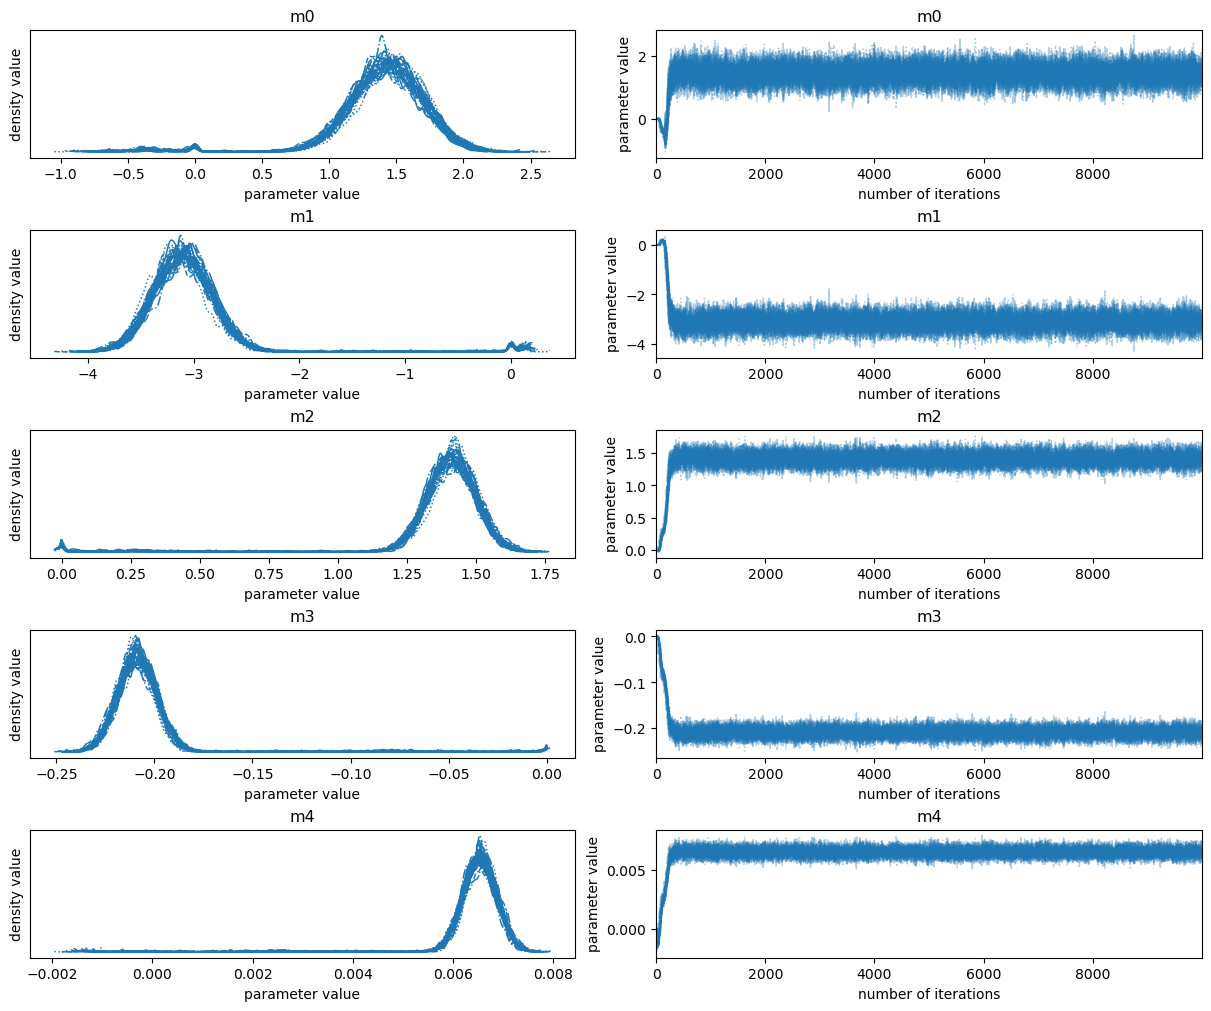

In [33]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True}); 

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    #ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [34]:
#tau = sampler.get_autocorr_time()
#print(f"autocorrelation time: {tau}")

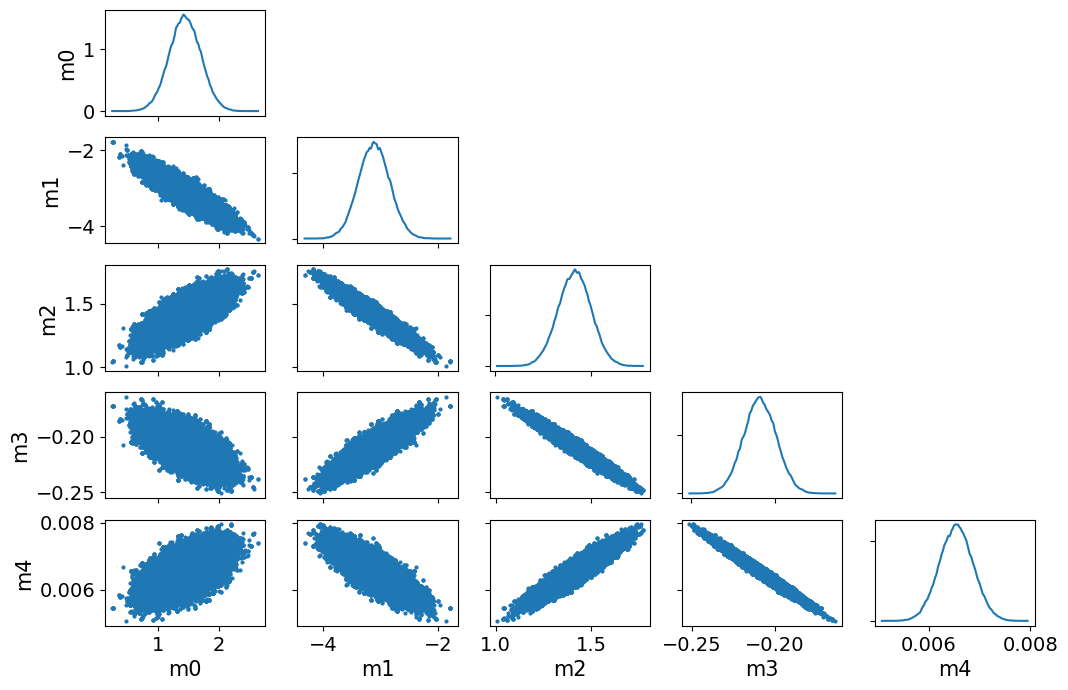

In [35]:
# a Corner plot

fig, axes = plt.subplots(nparams, nparams, figsize=(12,8))

if(True): # if we are plotting the model ensemble use this
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        ax=axes,
    );
else: # if we wish to plot a kernel density plot then use this option
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"},
        },
        ax=axes,
    );

Now we plot the predicted curves for the posterior ensemble of solutions.

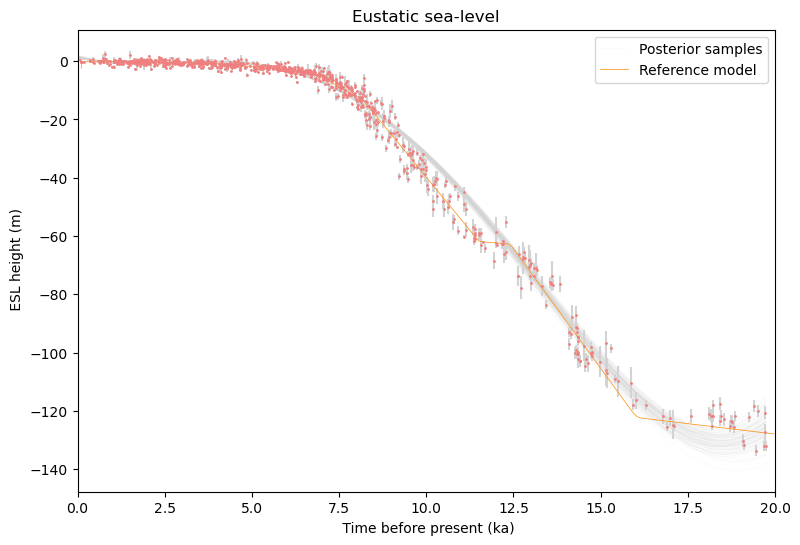

In [36]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data(title="Eustatic sea-level")
plt.xlim(0,maxtime)
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")
#plt.xlim(15,20.)
#plt.ylim(-140,-100)

#### Expected values, credible intervals and model covariance matrix from the ensemble

In [37]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0   1.435 [  1.019,   1.858]
 m1  -3.114 [ -3.554,  -2.673]
 m2   1.414 [  1.274,   1.552]
 m3  -0.209 [ -0.225,  -0.193]
 m4   0.007 [  0.006,   0.007]


In [38]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 6.64402734e-02 -6.17779292e-02  1.65119308e-02 -1.60193479e-03
   4.79004420e-05]
 [-6.17779292e-02  7.24199025e-02 -2.18405507e-02  2.28263351e-03
  -7.11899604e-05]
 [ 1.65119308e-02 -2.18405507e-02  7.23765423e-03 -8.08281865e-04
   2.61984602e-05]
 [-1.60193479e-03  2.28263351e-03 -8.08281865e-04  9.51065318e-05
  -3.18387781e-06]
 [ 4.79004420e-05 -7.11899604e-05  2.61984602e-05 -3.18387781e-06
   1.09362044e-07]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.2577
    m1  0.2691
    m2  0.0851
    m3  0.0098
    m4  0.0003


---------

### Challenge - Change the prior model bounds

Replace the previous prior bounds to new values

The original  uniform bounds had  

${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

Lets replace with

${\mathbf l}^T = (-0.5,-10.,-10.,-10.)$, and ${\mathbf u}^T = (0.5,10.,10.,10.)$.

We have only changed the bounds of the first parameter. However since the true value of constant term was 6, these bounds are now inconsistent with the true model.

What does this do to the posterior distribution?

Start from the code template below:

```
m_lower_bound = <CHANGE ME>             # lower bound for uniform prior
m_upper_bound = <CHANGE ME>             # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of <CHANGE ME>, upper bounds of <CHANGE ME>")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")
```

In [39]:
# Copy the template above, Replace <CHANGE ME> with your answer



  0%|                                                                                                                                                       | 0/10000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                            | 15/10000 [00:00<01:11, 140.25it/s]

  0%|▍                                                                                                                                            | 30/10000 [00:00<01:11, 140.41it/s]

  0%|▋                                                                                                                                            | 45/10000 [00:00<01:10, 140.28it/s]

  1%|▊                                                                                                                                            | 60/10000 [00:00<01:10, 140.39it/s]

  1%|█                                                                                                                                            | 75/10000 [00:00<01:11, 138.57it/s]

  1%|█▎                                                                                                                                           | 90/10000 [00:00<01:11, 139.45it/s]

  1%|█▍                                                                                                                                          | 104/10000 [00:00<01:10, 139.50it/s]

  1%|█▋                                                                                                                                          | 119/10000 [00:00<01:10, 140.03it/s]

  1%|█▉                                                                                                                                          | 134/10000 [00:00<01:10, 140.26it/s]

  1%|██                                                                                                                                          | 149/10000 [00:01<01:10, 140.41it/s]

  2%|██▎                                                                                                                                         | 164/10000 [00:01<01:10, 140.45it/s]

  2%|██▌                                                                                                                                         | 179/10000 [00:01<01:09, 140.55it/s]

  2%|██▋                                                                                                                                         | 194/10000 [00:01<01:09, 140.59it/s]

  2%|██▉                                                                                                                                         | 209/10000 [00:01<01:09, 140.76it/s]

  2%|███▏                                                                                                                                        | 224/10000 [00:01<01:09, 140.84it/s]

  2%|███▎                                                                                                                                        | 239/10000 [00:01<01:09, 140.08it/s]

  3%|███▌                                                                                                                                        | 254/10000 [00:01<01:09, 140.25it/s]

  3%|███▊                                                                                                                                        | 269/10000 [00:01<01:09, 140.50it/s]

  3%|███▉                                                                                                                                        | 284/10000 [00:02<01:09, 140.51it/s]

  3%|████▏                                                                                                                                       | 299/10000 [00:02<01:09, 138.91it/s]

  3%|████▍                                                                                                                                       | 314/10000 [00:02<01:09, 139.58it/s]

  3%|████▌                                                                                                                                       | 328/10000 [00:02<01:21, 119.15it/s]

  3%|████▊                                                                                                                                       | 342/10000 [00:02<01:17, 123.95it/s]

  4%|████▉                                                                                                                                       | 356/10000 [00:02<01:15, 127.90it/s]

  4%|█████▏                                                                                                                                      | 370/10000 [00:02<01:13, 130.92it/s]

  4%|█████▍                                                                                                                                      | 384/10000 [00:02<01:12, 133.29it/s]

  4%|█████▌                                                                                                                                      | 398/10000 [00:02<01:11, 134.95it/s]

  4%|█████▊                                                                                                                                      | 412/10000 [00:03<01:10, 135.76it/s]

  4%|█████▉                                                                                                                                      | 426/10000 [00:03<01:10, 136.61it/s]

  4%|██████▏                                                                                                                                     | 440/10000 [00:03<01:09, 137.34it/s]

  5%|██████▎                                                                                                                                     | 454/10000 [00:03<01:09, 137.80it/s]

  5%|██████▌                                                                                                                                     | 468/10000 [00:03<01:08, 138.31it/s]

  5%|██████▋                                                                                                                                     | 482/10000 [00:03<01:08, 138.43it/s]

  5%|██████▉                                                                                                                                     | 496/10000 [00:03<01:08, 138.58it/s]

  5%|███████▏                                                                                                                                    | 510/10000 [00:03<01:08, 138.74it/s]

  5%|███████▎                                                                                                                                    | 524/10000 [00:03<01:08, 138.75it/s]

  5%|███████▌                                                                                                                                    | 538/10000 [00:03<01:08, 138.88it/s]

  6%|███████▋                                                                                                                                    | 552/10000 [00:04<01:07, 138.96it/s]

  6%|███████▉                                                                                                                                    | 566/10000 [00:04<01:07, 138.99it/s]

  6%|████████                                                                                                                                    | 580/10000 [00:04<01:07, 139.05it/s]

  6%|████████▎                                                                                                                                   | 594/10000 [00:04<01:07, 139.18it/s]

  6%|████████▌                                                                                                                                   | 608/10000 [00:04<01:07, 139.36it/s]

  6%|████████▋                                                                                                                                   | 622/10000 [00:04<01:07, 139.49it/s]

  6%|████████▉                                                                                                                                   | 636/10000 [00:04<01:07, 139.58it/s]

  6%|█████████                                                                                                                                   | 650/10000 [00:04<01:06, 139.68it/s]

  7%|█████████▎                                                                                                                                  | 664/10000 [00:04<01:06, 139.76it/s]

  7%|█████████▍                                                                                                                                  | 678/10000 [00:04<01:06, 139.82it/s]

  7%|█████████▋                                                                                                                                  | 692/10000 [00:05<01:06, 139.68it/s]

  7%|█████████▉                                                                                                                                  | 706/10000 [00:05<01:07, 137.84it/s]

  7%|██████████                                                                                                                                  | 720/10000 [00:05<01:07, 138.43it/s]

  7%|██████████▎                                                                                                                                 | 734/10000 [00:05<01:06, 138.71it/s]

  7%|██████████▍                                                                                                                                 | 749/10000 [00:05<01:06, 139.15it/s]

  8%|██████████▋                                                                                                                                 | 763/10000 [00:05<01:06, 139.25it/s]

  8%|██████████▉                                                                                                                                 | 777/10000 [00:05<01:07, 137.56it/s]

  8%|███████████                                                                                                                                 | 791/10000 [00:05<01:07, 136.02it/s]

  8%|███████████▎                                                                                                                                | 805/10000 [00:05<01:07, 136.83it/s]

  8%|███████████▍                                                                                                                                | 819/10000 [00:05<01:06, 137.73it/s]

  8%|███████████▋                                                                                                                                | 833/10000 [00:06<01:06, 138.27it/s]

  8%|███████████▊                                                                                                                                | 847/10000 [00:06<01:05, 138.76it/s]

  9%|████████████                                                                                                                                | 861/10000 [00:06<01:05, 138.96it/s]

  9%|████████████▎                                                                                                                               | 875/10000 [00:06<01:05, 139.21it/s]

  9%|████████████▍                                                                                                                               | 889/10000 [00:06<01:06, 136.17it/s]

  9%|████████████▋                                                                                                                               | 903/10000 [00:06<01:06, 136.38it/s]

  9%|████████████▊                                                                                                                               | 917/10000 [00:06<01:06, 137.40it/s]

  9%|█████████████                                                                                                                               | 931/10000 [00:06<01:05, 138.01it/s]

  9%|█████████████▏                                                                                                                              | 945/10000 [00:06<01:05, 138.41it/s]

 10%|█████████████▍                                                                                                                              | 959/10000 [00:06<01:05, 138.77it/s]

 10%|█████████████▌                                                                                                                              | 973/10000 [00:07<01:04, 138.97it/s]

 10%|█████████████▊                                                                                                                              | 987/10000 [00:07<01:04, 139.12it/s]

 10%|█████████████▉                                                                                                                             | 1002/10000 [00:07<01:04, 139.45it/s]

 10%|██████████████                                                                                                                             | 1016/10000 [00:07<01:04, 139.57it/s]

 10%|██████████████▎                                                                                                                            | 1031/10000 [00:07<01:04, 139.76it/s]

 10%|██████████████▌                                                                                                                            | 1046/10000 [00:07<01:04, 139.90it/s]

 11%|██████████████▋                                                                                                                            | 1060/10000 [00:07<01:03, 139.93it/s]

 11%|██████████████▉                                                                                                                            | 1075/10000 [00:07<01:03, 140.05it/s]

 11%|███████████████▏                                                                                                                           | 1090/10000 [00:07<01:03, 140.15it/s]

 11%|███████████████▎                                                                                                                           | 1105/10000 [00:07<01:03, 140.17it/s]

 11%|███████████████▌                                                                                                                           | 1120/10000 [00:08<01:04, 138.46it/s]

 11%|███████████████▊                                                                                                                           | 1135/10000 [00:08<01:03, 138.99it/s]

 12%|███████████████▉                                                                                                                           | 1150/10000 [00:08<01:03, 139.38it/s]

 12%|████████████████▏                                                                                                                          | 1164/10000 [00:08<01:03, 139.55it/s]

 12%|████████████████▎                                                                                                                          | 1178/10000 [00:08<01:03, 139.58it/s]

 12%|████████████████▌                                                                                                                          | 1193/10000 [00:08<01:02, 139.80it/s]

 12%|████████████████▊                                                                                                                          | 1207/10000 [00:08<01:03, 138.17it/s]

 12%|████████████████▉                                                                                                                          | 1222/10000 [00:08<01:03, 138.82it/s]

 12%|█████████████████▏                                                                                                                         | 1236/10000 [00:08<01:03, 137.79it/s]

 12%|█████████████████▍                                                                                                                         | 1250/10000 [00:09<01:03, 138.26it/s]

 13%|█████████████████▌                                                                                                                         | 1264/10000 [00:09<01:02, 138.67it/s]

 13%|█████████████████▊                                                                                                                         | 1278/10000 [00:09<01:02, 138.69it/s]

 13%|█████████████████▉                                                                                                                         | 1292/10000 [00:09<01:02, 138.28it/s]

 13%|██████████████████▏                                                                                                                        | 1306/10000 [00:09<01:02, 138.78it/s]

 13%|██████████████████▎                                                                                                                        | 1321/10000 [00:09<01:02, 139.29it/s]

 13%|██████████████████▌                                                                                                                        | 1336/10000 [00:09<01:02, 139.63it/s]

 14%|██████████████████▊                                                                                                                        | 1350/10000 [00:09<01:01, 139.68it/s]

 14%|██████████████████▉                                                                                                                        | 1365/10000 [00:09<01:01, 139.84it/s]

 14%|███████████████████▏                                                                                                                       | 1380/10000 [00:09<01:01, 139.98it/s]

 14%|███████████████████▍                                                                                                                       | 1394/10000 [00:10<01:01, 139.87it/s]

 14%|███████████████████▌                                                                                                                       | 1408/10000 [00:10<01:01, 139.53it/s]

 14%|███████████████████▊                                                                                                                       | 1423/10000 [00:10<01:01, 139.86it/s]

 14%|███████████████████▉                                                                                                                       | 1438/10000 [00:10<01:01, 140.00it/s]

 15%|████████████████████▏                                                                                                                      | 1453/10000 [00:10<01:01, 140.05it/s]

 15%|████████████████████▍                                                                                                                      | 1468/10000 [00:10<01:00, 139.99it/s]

 15%|████████████████████▌                                                                                                                      | 1482/10000 [00:10<01:00, 139.91it/s]

 15%|████████████████████▊                                                                                                                      | 1496/10000 [00:10<01:00, 139.87it/s]

 15%|████████████████████▉                                                                                                                      | 1510/10000 [00:10<01:00, 139.84it/s]

 15%|█████████████████████▏                                                                                                                     | 1524/10000 [00:11<01:02, 136.39it/s]

 15%|█████████████████████▍                                                                                                                     | 1538/10000 [00:11<01:07, 124.66it/s]

 16%|█████████████████████▌                                                                                                                     | 1552/10000 [00:11<01:05, 128.06it/s]

 16%|█████████████████████▊                                                                                                                     | 1567/10000 [00:11<01:04, 131.66it/s]

 16%|█████████████████████▉                                                                                                                     | 1582/10000 [00:11<01:02, 134.22it/s]

 16%|██████████████████████▏                                                                                                                    | 1597/10000 [00:11<01:01, 136.05it/s]

 16%|██████████████████████▍                                                                                                                    | 1612/10000 [00:11<01:01, 137.33it/s]

 16%|██████████████████████▌                                                                                                                    | 1627/10000 [00:11<01:00, 138.37it/s]

 16%|██████████████████████▊                                                                                                                    | 1642/10000 [00:11<01:00, 138.98it/s]

 17%|███████████████████████                                                                                                                    | 1656/10000 [00:11<00:59, 139.20it/s]

 17%|███████████████████████▏                                                                                                                   | 1671/10000 [00:12<00:59, 139.58it/s]

 17%|███████████████████████▍                                                                                                                   | 1686/10000 [00:12<00:59, 139.99it/s]

 17%|███████████████████████▋                                                                                                                   | 1701/10000 [00:12<00:59, 140.17it/s]

 17%|███████████████████████▊                                                                                                                   | 1716/10000 [00:12<00:59, 139.76it/s]

 17%|████████████████████████                                                                                                                   | 1731/10000 [00:12<00:59, 139.93it/s]

 17%|████████████████████████▎                                                                                                                  | 1746/10000 [00:12<00:58, 140.04it/s]

 18%|████████████████████████▍                                                                                                                  | 1761/10000 [00:12<00:58, 140.00it/s]

 18%|████████████████████████▋                                                                                                                  | 1776/10000 [00:12<00:58, 139.98it/s]

 18%|████████████████████████▉                                                                                                                  | 1791/10000 [00:12<00:58, 140.13it/s]

 18%|█████████████████████████                                                                                                                  | 1806/10000 [00:13<01:07, 121.13it/s]

 18%|█████████████████████████▎                                                                                                                 | 1821/10000 [00:13<01:04, 126.40it/s]

 18%|█████████████████████████▌                                                                                                                 | 1835/10000 [00:13<01:02, 129.96it/s]

 18%|█████████████████████████▋                                                                                                                 | 1850/10000 [00:13<01:01, 133.12it/s]

 19%|█████████████████████████▉                                                                                                                 | 1864/10000 [00:13<01:00, 135.01it/s]

 19%|██████████████████████████                                                                                                                 | 1879/10000 [00:13<00:59, 136.53it/s]

 19%|██████████████████████████▎                                                                                                                | 1894/10000 [00:13<00:58, 137.77it/s]

 19%|██████████████████████████▌                                                                                                                | 1909/10000 [00:13<00:58, 138.75it/s]

 19%|██████████████████████████▋                                                                                                                | 1924/10000 [00:13<00:57, 139.28it/s]

 19%|██████████████████████████▉                                                                                                                | 1938/10000 [00:14<00:57, 139.46it/s]

 20%|███████████████████████████▏                                                                                                               | 1952/10000 [00:14<00:59, 136.04it/s]

 20%|███████████████████████████▎                                                                                                               | 1966/10000 [00:14<00:58, 136.73it/s]

 20%|███████████████████████████▌                                                                                                               | 1981/10000 [00:14<00:58, 137.83it/s]

 20%|███████████████████████████▋                                                                                                               | 1996/10000 [00:14<00:57, 138.59it/s]

 20%|███████████████████████████▉                                                                                                               | 2010/10000 [00:14<00:57, 138.98it/s]

 20%|████████████████████████████▏                                                                                                              | 2025/10000 [00:14<00:57, 139.45it/s]

 20%|████████████████████████████▎                                                                                                              | 2040/10000 [00:14<00:56, 139.74it/s]

 21%|████████████████████████████▌                                                                                                              | 2055/10000 [00:14<00:56, 139.87it/s]

 21%|████████████████████████████▊                                                                                                              | 2069/10000 [00:15<00:56, 139.81it/s]

 21%|████████████████████████████▉                                                                                                              | 2083/10000 [00:15<00:56, 139.86it/s]

 21%|█████████████████████████████▏                                                                                                             | 2097/10000 [00:15<00:56, 139.86it/s]

 21%|█████████████████████████████▎                                                                                                             | 2112/10000 [00:15<00:56, 140.12it/s]

 21%|█████████████████████████████▌                                                                                                             | 2127/10000 [00:15<00:56, 140.32it/s]

 21%|█████████████████████████████▊                                                                                                             | 2142/10000 [00:15<00:55, 140.39it/s]

 22%|█████████████████████████████▉                                                                                                             | 2157/10000 [00:15<00:55, 140.51it/s]

 22%|██████████████████████████████▏                                                                                                            | 2172/10000 [00:15<00:56, 139.66it/s]

 22%|██████████████████████████████▍                                                                                                            | 2186/10000 [00:15<00:56, 139.30it/s]

 22%|██████████████████████████████▌                                                                                                            | 2200/10000 [00:15<00:56, 139.28it/s]

 22%|██████████████████████████████▊                                                                                                            | 2214/10000 [00:16<00:55, 139.17it/s]

 22%|██████████████████████████████▉                                                                                                            | 2228/10000 [00:16<00:55, 139.33it/s]

 22%|███████████████████████████████▏                                                                                                           | 2242/10000 [00:16<00:55, 139.30it/s]

 23%|███████████████████████████████▎                                                                                                           | 2256/10000 [00:16<00:55, 139.15it/s]

 23%|███████████████████████████████▌                                                                                                           | 2270/10000 [00:16<00:55, 138.90it/s]

 23%|███████████████████████████████▋                                                                                                           | 2284/10000 [00:16<00:55, 139.04it/s]

 23%|███████████████████████████████▉                                                                                                           | 2298/10000 [00:16<00:55, 139.21it/s]

 23%|████████████████████████████████▏                                                                                                          | 2312/10000 [00:16<00:55, 139.23it/s]

 23%|████████████████████████████████▎                                                                                                          | 2326/10000 [00:16<00:55, 139.27it/s]

 23%|████████████████████████████████▌                                                                                                          | 2340/10000 [00:16<00:55, 139.22it/s]

 24%|████████████████████████████████▋                                                                                                          | 2354/10000 [00:17<00:54, 139.05it/s]

 24%|████████████████████████████████▉                                                                                                          | 2368/10000 [00:17<00:55, 137.40it/s]

 24%|█████████████████████████████████                                                                                                          | 2382/10000 [00:17<00:55, 137.97it/s]

 24%|█████████████████████████████████▎                                                                                                         | 2396/10000 [00:17<00:54, 138.53it/s]

 24%|█████████████████████████████████▍                                                                                                         | 2410/10000 [00:17<00:54, 138.91it/s]

 24%|█████████████████████████████████▋                                                                                                         | 2424/10000 [00:17<00:54, 139.10it/s]

 24%|█████████████████████████████████▉                                                                                                         | 2438/10000 [00:17<00:54, 139.29it/s]

 25%|██████████████████████████████████                                                                                                         | 2452/10000 [00:17<00:54, 139.49it/s]

 25%|██████████████████████████████████▎                                                                                                        | 2466/10000 [00:17<00:53, 139.59it/s]

 25%|██████████████████████████████████▍                                                                                                        | 2480/10000 [00:17<00:53, 139.61it/s]

 25%|██████████████████████████████████▋                                                                                                        | 2494/10000 [00:18<00:53, 139.49it/s]

 25%|██████████████████████████████████▊                                                                                                        | 2508/10000 [00:18<00:53, 138.97it/s]

 25%|███████████████████████████████████                                                                                                        | 2523/10000 [00:18<00:53, 139.50it/s]

 25%|███████████████████████████████████▎                                                                                                       | 2538/10000 [00:18<00:53, 139.79it/s]

 26%|███████████████████████████████████▍                                                                                                       | 2553/10000 [00:18<00:53, 140.09it/s]

 26%|███████████████████████████████████▋                                                                                                       | 2568/10000 [00:18<00:53, 140.16it/s]

 26%|███████████████████████████████████▉                                                                                                       | 2583/10000 [00:18<00:52, 140.35it/s]

 26%|████████████████████████████████████                                                                                                       | 2598/10000 [00:18<00:52, 140.47it/s]

 26%|████████████████████████████████████▎                                                                                                      | 2613/10000 [00:18<00:52, 140.38it/s]

 26%|████████████████████████████████████▌                                                                                                      | 2628/10000 [00:19<00:52, 140.18it/s]

 26%|████████████████████████████████████▋                                                                                                      | 2643/10000 [00:19<00:52, 140.19it/s]

 27%|████████████████████████████████████▉                                                                                                      | 2658/10000 [00:19<00:52, 140.21it/s]

 27%|█████████████████████████████████████▏                                                                                                     | 2673/10000 [00:19<00:52, 139.55it/s]

 27%|█████████████████████████████████████▎                                                                                                     | 2688/10000 [00:19<00:52, 139.90it/s]

 27%|█████████████████████████████████████▌                                                                                                     | 2703/10000 [00:19<00:52, 140.05it/s]

 27%|█████████████████████████████████████▊                                                                                                     | 2718/10000 [00:19<00:51, 140.11it/s]

 27%|█████████████████████████████████████▉                                                                                                     | 2733/10000 [00:19<00:51, 140.41it/s]

 27%|██████████████████████████████████████▏                                                                                                    | 2748/10000 [00:19<00:51, 140.16it/s]

 28%|██████████████████████████████████████▍                                                                                                    | 2763/10000 [00:19<00:51, 140.37it/s]

 28%|██████████████████████████████████████▌                                                                                                    | 2778/10000 [00:20<00:51, 140.46it/s]

 28%|██████████████████████████████████████▊                                                                                                    | 2793/10000 [00:20<00:51, 138.94it/s]

 28%|███████████████████████████████████████                                                                                                    | 2808/10000 [00:20<00:51, 139.48it/s]

 28%|███████████████████████████████████████▏                                                                                                   | 2823/10000 [00:20<00:51, 139.94it/s]

 28%|███████████████████████████████████████▍                                                                                                   | 2838/10000 [00:20<00:51, 140.15it/s]

 29%|███████████████████████████████████████▋                                                                                                   | 2853/10000 [00:20<00:50, 140.38it/s]

 29%|███████████████████████████████████████▊                                                                                                   | 2868/10000 [00:20<00:50, 140.49it/s]

 29%|████████████████████████████████████████                                                                                                   | 2883/10000 [00:20<00:50, 140.65it/s]

 29%|████████████████████████████████████████▎                                                                                                  | 2898/10000 [00:20<00:50, 140.78it/s]

 29%|████████████████████████████████████████▍                                                                                                  | 2913/10000 [00:21<00:50, 140.78it/s]

 29%|████████████████████████████████████████▋                                                                                                  | 2928/10000 [00:21<00:50, 140.69it/s]

 29%|████████████████████████████████████████▉                                                                                                  | 2943/10000 [00:21<00:50, 140.74it/s]

 30%|█████████████████████████████████████████                                                                                                  | 2958/10000 [00:21<00:50, 140.70it/s]

 30%|█████████████████████████████████████████▎                                                                                                 | 2973/10000 [00:21<00:49, 140.75it/s]

 30%|█████████████████████████████████████████▌                                                                                                 | 2988/10000 [00:21<00:49, 140.68it/s]

 30%|█████████████████████████████████████████▋                                                                                                 | 3003/10000 [00:21<00:49, 140.61it/s]

 30%|█████████████████████████████████████████▉                                                                                                 | 3018/10000 [00:21<00:49, 140.58it/s]

 30%|██████████████████████████████████████████▏                                                                                                | 3033/10000 [00:21<00:49, 140.64it/s]

 30%|██████████████████████████████████████████▎                                                                                                | 3048/10000 [00:22<00:49, 140.59it/s]

 31%|██████████████████████████████████████████▌                                                                                                | 3063/10000 [00:22<00:49, 140.66it/s]

 31%|██████████████████████████████████████████▊                                                                                                | 3078/10000 [00:22<00:49, 140.67it/s]

 31%|██████████████████████████████████████████▉                                                                                                | 3093/10000 [00:22<00:49, 140.54it/s]

 31%|███████████████████████████████████████████▏                                                                                               | 3108/10000 [00:22<00:49, 140.62it/s]

 31%|███████████████████████████████████████████▍                                                                                               | 3123/10000 [00:22<00:48, 140.53it/s]

 31%|███████████████████████████████████████████▌                                                                                               | 3138/10000 [00:22<00:48, 140.73it/s]

 32%|███████████████████████████████████████████▊                                                                                               | 3153/10000 [00:22<00:48, 140.58it/s]

 32%|████████████████████████████████████████████                                                                                               | 3168/10000 [00:22<00:48, 140.62it/s]

 32%|████████████████████████████████████████████▏                                                                                              | 3183/10000 [00:22<00:48, 140.72it/s]

 32%|████████████████████████████████████████████▍                                                                                              | 3198/10000 [00:23<00:48, 140.75it/s]

 32%|████████████████████████████████████████████▋                                                                                              | 3213/10000 [00:23<00:49, 138.50it/s]

 32%|████████████████████████████████████████████▊                                                                                              | 3228/10000 [00:23<00:48, 139.13it/s]

 32%|█████████████████████████████████████████████                                                                                              | 3243/10000 [00:23<00:48, 139.73it/s]

 33%|█████████████████████████████████████████████▎                                                                                             | 3258/10000 [00:23<00:48, 140.23it/s]

 33%|█████████████████████████████████████████████▍                                                                                             | 3273/10000 [00:23<00:47, 140.56it/s]

 33%|█████████████████████████████████████████████▋                                                                                             | 3288/10000 [00:23<00:47, 140.56it/s]

 33%|█████████████████████████████████████████████▉                                                                                             | 3303/10000 [00:23<00:47, 140.76it/s]

 33%|██████████████████████████████████████████████                                                                                             | 3318/10000 [00:23<00:47, 140.93it/s]

 33%|██████████████████████████████████████████████▎                                                                                            | 3333/10000 [00:24<00:47, 140.91it/s]

 33%|██████████████████████████████████████████████▌                                                                                            | 3348/10000 [00:24<00:47, 141.01it/s]

 34%|██████████████████████████████████████████████▋                                                                                            | 3363/10000 [00:24<00:47, 141.09it/s]

 34%|██████████████████████████████████████████████▉                                                                                            | 3378/10000 [00:24<00:47, 140.47it/s]

 34%|███████████████████████████████████████████████▏                                                                                           | 3393/10000 [00:24<00:46, 140.78it/s]

 34%|███████████████████████████████████████████████▎                                                                                           | 3408/10000 [00:24<00:46, 140.83it/s]

 34%|███████████████████████████████████████████████▌                                                                                           | 3423/10000 [00:24<00:46, 140.74it/s]

 34%|███████████████████████████████████████████████▊                                                                                           | 3438/10000 [00:24<00:46, 140.84it/s]

 35%|███████████████████████████████████████████████▉                                                                                           | 3453/10000 [00:24<00:46, 140.69it/s]

 35%|████████████████████████████████████████████████▏                                                                                          | 3468/10000 [00:24<00:46, 140.78it/s]

 35%|████████████████████████████████████████████████▍                                                                                          | 3483/10000 [00:25<00:46, 140.78it/s]

 35%|████████████████████████████████████████████████▌                                                                                          | 3498/10000 [00:25<00:46, 140.82it/s]

 35%|████████████████████████████████████████████████▊                                                                                          | 3513/10000 [00:25<00:46, 140.94it/s]

 35%|█████████████████████████████████████████████████                                                                                          | 3528/10000 [00:25<00:45, 140.89it/s]

 35%|█████████████████████████████████████████████████▏                                                                                         | 3543/10000 [00:25<00:45, 141.03it/s]

 36%|█████████████████████████████████████████████████▍                                                                                         | 3558/10000 [00:25<00:45, 141.12it/s]

 36%|█████████████████████████████████████████████████▋                                                                                         | 3573/10000 [00:25<00:46, 138.27it/s]

 36%|█████████████████████████████████████████████████▊                                                                                         | 3587/10000 [00:25<00:46, 136.77it/s]

 36%|██████████████████████████████████████████████████                                                                                         | 3602/10000 [00:25<00:46, 138.03it/s]

 36%|██████████████████████████████████████████████████▎                                                                                        | 3617/10000 [00:26<00:46, 138.75it/s]

 36%|██████████████████████████████████████████████████▍                                                                                        | 3631/10000 [00:26<00:46, 136.48it/s]

 36%|██████████████████████████████████████████████████▋                                                                                        | 3646/10000 [00:26<00:46, 137.71it/s]

 37%|██████████████████████████████████████████████████▊                                                                                        | 3660/10000 [00:26<00:46, 136.80it/s]

 37%|███████████████████████████████████████████████████                                                                                        | 3675/10000 [00:26<00:45, 138.11it/s]

 37%|███████████████████████████████████████████████████▎                                                                                       | 3690/10000 [00:26<00:45, 137.99it/s]

 37%|███████████████████████████████████████████████████▍                                                                                       | 3704/10000 [00:26<00:45, 138.31it/s]

 37%|███████████████████████████████████████████████████▋                                                                                       | 3719/10000 [00:26<00:45, 139.10it/s]

 37%|███████████████████████████████████████████████████▉                                                                                       | 3733/10000 [00:26<00:45, 138.09it/s]

 37%|████████████████████████████████████████████████████                                                                                       | 3748/10000 [00:27<00:45, 138.86it/s]

 38%|████████████████████████████████████████████████████▎                                                                                      | 3763/10000 [00:27<00:44, 139.52it/s]

 38%|████████████████████████████████████████████████████▌                                                                                      | 3777/10000 [00:27<00:44, 139.61it/s]

 38%|████████████████████████████████████████████████████▋                                                                                      | 3791/10000 [00:27<00:44, 139.70it/s]

 38%|████████████████████████████████████████████████████▉                                                                                      | 3806/10000 [00:27<00:44, 140.19it/s]

 38%|█████████████████████████████████████████████████████                                                                                      | 3821/10000 [00:27<00:43, 140.49it/s]

 38%|█████████████████████████████████████████████████████▎                                                                                     | 3836/10000 [00:27<00:43, 140.31it/s]

 39%|█████████████████████████████████████████████████████▌                                                                                     | 3851/10000 [00:27<00:43, 139.91it/s]

 39%|█████████████████████████████████████████████████████▋                                                                                     | 3866/10000 [00:27<00:43, 140.23it/s]

 39%|█████████████████████████████████████████████████████▉                                                                                     | 3881/10000 [00:27<00:43, 140.57it/s]

 39%|██████████████████████████████████████████████████████▏                                                                                    | 3896/10000 [00:28<00:43, 140.48it/s]

 39%|██████████████████████████████████████████████████████▎                                                                                    | 3911/10000 [00:28<00:43, 140.64it/s]

 39%|██████████████████████████████████████████████████████▌                                                                                    | 3926/10000 [00:28<00:43, 140.73it/s]

 39%|██████████████████████████████████████████████████████▊                                                                                    | 3941/10000 [00:28<00:43, 140.73it/s]

 40%|██████████████████████████████████████████████████████▉                                                                                    | 3956/10000 [00:28<00:42, 140.85it/s]

 40%|███████████████████████████████████████████████████████▏                                                                                   | 3971/10000 [00:28<00:42, 140.93it/s]

 40%|███████████████████████████████████████████████████████▍                                                                                   | 3986/10000 [00:28<00:42, 140.90it/s]

 40%|███████████████████████████████████████████████████████▌                                                                                   | 4001/10000 [00:28<00:42, 141.03it/s]

 40%|███████████████████████████████████████████████████████▊                                                                                   | 4016/10000 [00:28<00:42, 140.41it/s]

 40%|████████████████████████████████████████████████████████                                                                                   | 4031/10000 [00:29<00:42, 140.56it/s]

 40%|████████████████████████████████████████████████████████▏                                                                                  | 4046/10000 [00:29<00:42, 138.96it/s]

 41%|████████████████████████████████████████████████████████▍                                                                                  | 4061/10000 [00:29<00:42, 139.61it/s]

 41%|████████████████████████████████████████████████████████▋                                                                                  | 4075/10000 [00:29<00:42, 139.31it/s]

 41%|████████████████████████████████████████████████████████▊                                                                                  | 4090/10000 [00:29<00:42, 139.87it/s]

 41%|█████████████████████████████████████████████████████████                                                                                  | 4105/10000 [00:29<00:42, 140.04it/s]

 41%|█████████████████████████████████████████████████████████▎                                                                                 | 4120/10000 [00:29<00:41, 140.36it/s]

 41%|█████████████████████████████████████████████████████████▍                                                                                 | 4135/10000 [00:29<00:41, 140.60it/s]

 42%|█████████████████████████████████████████████████████████▋                                                                                 | 4150/10000 [00:29<00:41, 140.24it/s]

 42%|█████████████████████████████████████████████████████████▉                                                                                 | 4165/10000 [00:29<00:41, 140.67it/s]

 42%|██████████████████████████████████████████████████████████                                                                                 | 4180/10000 [00:30<00:53, 108.32it/s]

 42%|██████████████████████████████████████████████████████████▎                                                                                | 4194/10000 [00:30<00:50, 115.57it/s]

 42%|██████████████████████████████████████████████████████████▍                                                                                | 4208/10000 [00:30<00:47, 121.72it/s]

 42%|██████████████████████████████████████████████████████████▋                                                                                | 4222/10000 [00:30<00:45, 126.47it/s]

 42%|██████████████████████████████████████████████████████████▉                                                                                | 4236/10000 [00:30<00:44, 129.94it/s]

 43%|███████████████████████████████████████████████████████████                                                                                | 4251/10000 [00:30<00:43, 133.00it/s]

 43%|███████████████████████████████████████████████████████████▎                                                                               | 4266/10000 [00:30<00:42, 135.15it/s]

 43%|███████████████████████████████████████████████████████████▌                                                                               | 4281/10000 [00:30<00:41, 136.94it/s]

 43%|███████████████████████████████████████████████████████████▋                                                                               | 4296/10000 [00:31<00:41, 138.07it/s]

 43%|███████████████████████████████████████████████████████████▉                                                                               | 4311/10000 [00:31<00:40, 138.94it/s]

 43%|████████████████████████████████████████████████████████████▏                                                                              | 4326/10000 [00:31<00:40, 139.49it/s]

 43%|████████████████████████████████████████████████████████████▎                                                                              | 4341/10000 [00:31<00:40, 139.11it/s]

 44%|████████████████████████████████████████████████████████████▌                                                                              | 4356/10000 [00:31<00:40, 139.47it/s]

 44%|████████████████████████████████████████████████████████████▋                                                                              | 4370/10000 [00:31<00:40, 138.24it/s]

 44%|████████████████████████████████████████████████████████████▉                                                                              | 4385/10000 [00:31<00:40, 139.11it/s]

 44%|█████████████████████████████████████████████████████████████▏                                                                             | 4399/10000 [00:31<00:40, 138.79it/s]

 44%|█████████████████████████████████████████████████████████████▎                                                                             | 4413/10000 [00:31<00:40, 137.88it/s]

 44%|█████████████████████████████████████████████████████████████▌                                                                             | 4428/10000 [00:31<00:40, 138.81it/s]

 44%|█████████████████████████████████████████████████████████████▋                                                                             | 4442/10000 [00:32<00:40, 138.71it/s]

 45%|█████████████████████████████████████████████████████████████▉                                                                             | 4456/10000 [00:32<00:40, 137.40it/s]

 45%|██████████████████████████████████████████████████████████████▏                                                                            | 4471/10000 [00:32<00:40, 137.63it/s]

 45%|██████████████████████████████████████████████████████████████▎                                                                            | 4486/10000 [00:32<00:39, 138.57it/s]

 45%|██████████████████████████████████████████████████████████████▌                                                                            | 4501/10000 [00:32<00:39, 139.28it/s]

 45%|██████████████████████████████████████████████████████████████▊                                                                            | 4515/10000 [00:32<00:39, 139.11it/s]

 45%|██████████████████████████████████████████████████████████████▉                                                                            | 4529/10000 [00:32<00:39, 139.21it/s]

 45%|███████████████████████████████████████████████████████████████▏                                                                           | 4543/10000 [00:32<00:39, 139.40it/s]

 46%|███████████████████████████████████████████████████████████████▎                                                                           | 4558/10000 [00:32<00:38, 139.84it/s]

 46%|███████████████████████████████████████████████████████████████▌                                                                           | 4572/10000 [00:33<00:38, 139.84it/s]

 46%|███████████████████████████████████████████████████████████████▊                                                                           | 4587/10000 [00:33<00:38, 140.04it/s]

 46%|███████████████████████████████████████████████████████████████▉                                                                           | 4602/10000 [00:33<00:38, 139.92it/s]

 46%|████████████████████████████████████████████████████████████████▏                                                                          | 4616/10000 [00:33<00:38, 139.83it/s]

 46%|████████████████████████████████████████████████████████████████▎                                                                          | 4631/10000 [00:33<00:38, 140.04it/s]

 46%|████████████████████████████████████████████████████████████████▌                                                                          | 4646/10000 [00:33<00:38, 140.25it/s]

 47%|████████████████████████████████████████████████████████████████▊                                                                          | 4661/10000 [00:33<00:38, 140.38it/s]

 47%|████████████████████████████████████████████████████████████████▉                                                                          | 4676/10000 [00:33<00:37, 140.26it/s]

 47%|█████████████████████████████████████████████████████████████████▏                                                                         | 4691/10000 [00:33<00:37, 139.73it/s]

 47%|█████████████████████████████████████████████████████████████████▍                                                                         | 4705/10000 [00:33<00:37, 139.48it/s]

 47%|█████████████████████████████████████████████████████████████████▌                                                                         | 4719/10000 [00:34<00:37, 139.25it/s]

 47%|█████████████████████████████████████████████████████████████████▊                                                                         | 4733/10000 [00:34<00:37, 139.17it/s]

 47%|█████████████████████████████████████████████████████████████████▉                                                                         | 4747/10000 [00:34<00:37, 138.26it/s]

 48%|██████████████████████████████████████████████████████████████████▏                                                                        | 4761/10000 [00:34<00:37, 138.06it/s]

 48%|██████████████████████████████████████████████████████████████████▎                                                                        | 4775/10000 [00:34<00:37, 138.31it/s]

 48%|██████████████████████████████████████████████████████████████████▌                                                                        | 4789/10000 [00:34<00:37, 138.44it/s]

 48%|██████████████████████████████████████████████████████████████████▊                                                                        | 4803/10000 [00:34<00:37, 138.57it/s]

 48%|██████████████████████████████████████████████████████████████████▉                                                                        | 4817/10000 [00:34<00:37, 138.45it/s]

 48%|███████████████████████████████████████████████████████████████████▏                                                                       | 4831/10000 [00:34<00:37, 138.53it/s]

 48%|███████████████████████████████████████████████████████████████████▎                                                                       | 4845/10000 [00:34<00:37, 138.79it/s]

 49%|███████████████████████████████████████████████████████████████████▌                                                                       | 4859/10000 [00:35<00:36, 139.10it/s]

 49%|███████████████████████████████████████████████████████████████████▋                                                                       | 4873/10000 [00:35<00:37, 137.36it/s]

 49%|███████████████████████████████████████████████████████████████████▉                                                                       | 4887/10000 [00:35<00:37, 138.08it/s]

 49%|████████████████████████████████████████████████████████████████████                                                                       | 4901/10000 [00:35<00:36, 137.84it/s]

 49%|████████████████████████████████████████████████████████████████████▎                                                                      | 4915/10000 [00:35<00:36, 138.43it/s]

 49%|████████████████████████████████████████████████████████████████████▌                                                                      | 4930/10000 [00:35<00:36, 138.95it/s]

 49%|████████████████████████████████████████████████████████████████████▋                                                                      | 4944/10000 [00:35<00:36, 138.46it/s]

 50%|████████████████████████████████████████████████████████████████████▉                                                                      | 4958/10000 [00:35<00:36, 138.61it/s]

 50%|█████████████████████████████████████████████████████████████████████                                                                      | 4973/10000 [00:35<00:36, 139.08it/s]

 50%|█████████████████████████████████████████████████████████████████████▎                                                                     | 4987/10000 [00:35<00:35, 139.28it/s]

 50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 5001/10000 [00:36<00:35, 139.48it/s]

 50%|█████████████████████████████████████████████████████████████████████▋                                                                     | 5015/10000 [00:36<00:36, 135.30it/s]

 50%|█████████████████████████████████████████████████████████████████████▉                                                                     | 5029/10000 [00:36<00:36, 136.60it/s]

 50%|██████████████████████████████████████████████████████████████████████                                                                     | 5044/10000 [00:36<00:35, 137.67it/s]

 51%|██████████████████████████████████████████████████████████████████████▎                                                                    | 5059/10000 [00:36<00:35, 138.46it/s]

 51%|██████████████████████████████████████████████████████████████████████▌                                                                    | 5073/10000 [00:36<00:35, 138.90it/s]

 51%|██████████████████████████████████████████████████████████████████████▋                                                                    | 5087/10000 [00:36<00:35, 139.14it/s]

 51%|██████████████████████████████████████████████████████████████████████▉                                                                    | 5101/10000 [00:36<00:35, 139.35it/s]

 51%|███████████████████████████████████████████████████████████████████████                                                                    | 5116/10000 [00:36<00:34, 139.67it/s]

 51%|███████████████████████████████████████████████████████████████████████▎                                                                   | 5130/10000 [00:37<00:34, 139.70it/s]

 51%|███████████████████████████████████████████████████████████████████████▌                                                                   | 5145/10000 [00:37<00:34, 139.79it/s]

 52%|███████████████████████████████████████████████████████████████████████▋                                                                   | 5159/10000 [00:37<00:34, 139.50it/s]

 52%|███████████████████████████████████████████████████████████████████████▉                                                                   | 5173/10000 [00:37<00:34, 139.50it/s]

 52%|████████████████████████████████████████████████████████████████████████                                                                   | 5188/10000 [00:37<00:34, 139.69it/s]

 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 5203/10000 [00:37<00:34, 139.87it/s]

 52%|████████████████████████████████████████████████████████████████████████▌                                                                  | 5218/10000 [00:37<00:34, 139.95it/s]

 52%|████████████████████████████████████████████████████████████████████████▋                                                                  | 5232/10000 [00:37<00:34, 139.91it/s]

 52%|████████████████████████████████████████████████████████████████████████▉                                                                  | 5247/10000 [00:37<00:33, 139.97it/s]

 53%|█████████████████████████████████████████████████████████████████████████▏                                                                 | 5262/10000 [00:37<00:33, 140.02it/s]

 53%|█████████████████████████████████████████████████████████████████████████▎                                                                 | 5277/10000 [00:38<00:33, 139.94it/s]

 53%|█████████████████████████████████████████████████████████████████████████▌                                                                 | 5291/10000 [00:38<00:34, 138.04it/s]

 53%|█████████████████████████████████████████████████████████████████████████▋                                                                 | 5305/10000 [00:38<00:33, 138.58it/s]

 53%|█████████████████████████████████████████████████████████████████████████▉                                                                 | 5320/10000 [00:38<00:33, 139.05it/s]

 53%|██████████████████████████████████████████████████████████████████████████▏                                                                | 5334/10000 [00:38<00:33, 139.27it/s]

 53%|██████████████████████████████████████████████████████████████████████████▎                                                                | 5349/10000 [00:38<00:33, 139.54it/s]

 54%|██████████████████████████████████████████████████████████████████████████▌                                                                | 5363/10000 [00:38<00:33, 139.64it/s]

 54%|██████████████████████████████████████████████████████████████████████████▋                                                                | 5377/10000 [00:38<00:33, 139.66it/s]

 54%|██████████████████████████████████████████████████████████████████████████▉                                                                | 5391/10000 [00:38<00:32, 139.68it/s]

 54%|███████████████████████████████████████████████████████████████████████████▏                                                               | 5405/10000 [00:38<00:32, 139.62it/s]

 54%|███████████████████████████████████████████████████████████████████████████▎                                                               | 5419/10000 [00:39<00:32, 139.70it/s]

 54%|███████████████████████████████████████████████████████████████████████████▌                                                               | 5433/10000 [00:39<00:32, 139.02it/s]

 54%|███████████████████████████████████████████████████████████████████████████▋                                                               | 5447/10000 [00:39<00:33, 136.84it/s]

 55%|███████████████████████████████████████████████████████████████████████████▉                                                               | 5461/10000 [00:39<00:32, 137.61it/s]

 55%|████████████████████████████████████████████████████████████████████████████                                                               | 5475/10000 [00:39<00:32, 138.19it/s]

 55%|████████████████████████████████████████████████████████████████████████████▎                                                              | 5489/10000 [00:39<00:32, 138.69it/s]

 55%|████████████████████████████████████████████████████████████████████████████▍                                                              | 5503/10000 [00:39<00:32, 138.74it/s]

 55%|████████████████████████████████████████████████████████████████████████████▋                                                              | 5517/10000 [00:39<00:32, 138.94it/s]

 55%|████████████████████████████████████████████████████████████████████████████▉                                                              | 5531/10000 [00:39<00:32, 139.13it/s]

 55%|█████████████████████████████████████████████████████████████████████████████                                                              | 5545/10000 [00:40<00:32, 139.09it/s]

 56%|█████████████████████████████████████████████████████████████████████████████▎                                                             | 5559/10000 [00:40<00:31, 139.12it/s]

 56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 5573/10000 [00:40<00:31, 139.16it/s]

 56%|█████████████████████████████████████████████████████████████████████████████▋                                                             | 5587/10000 [00:40<00:31, 139.28it/s]

 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 5602/10000 [00:40<00:31, 139.58it/s]

 56%|██████████████████████████████████████████████████████████████████████████████                                                             | 5616/10000 [00:40<00:31, 139.65it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▎                                                            | 5630/10000 [00:40<00:31, 139.71it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▍                                                            | 5644/10000 [00:40<00:31, 139.62it/s]

 57%|██████████████████████████████████████████████████████████████████████████████▋                                                            | 5658/10000 [00:40<00:31, 139.46it/s]

 57%|██████████████████████████████████████████████████████████████████████████████▊                                                            | 5672/10000 [00:40<00:31, 139.47it/s]

 57%|███████████████████████████████████████████████████████████████████████████████                                                            | 5686/10000 [00:41<00:31, 138.96it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▏                                                           | 5700/10000 [00:41<00:31, 137.28it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 5715/10000 [00:41<00:30, 138.28it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▋                                                           | 5729/10000 [00:41<00:31, 136.92it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▊                                                           | 5744/10000 [00:41<00:30, 138.00it/s]

 58%|████████████████████████████████████████████████████████████████████████████████                                                           | 5759/10000 [00:41<00:30, 138.69it/s]

 58%|████████████████████████████████████████████████████████████████████████████████▏                                                          | 5773/10000 [00:41<00:30, 136.86it/s]

 58%|████████████████████████████████████████████████████████████████████████████████▍                                                          | 5787/10000 [00:41<00:30, 137.50it/s]

 58%|████████████████████████████████████████████████████████████████████████████████▋                                                          | 5801/10000 [00:41<00:30, 135.94it/s]

 58%|████████████████████████████████████████████████████████████████████████████████▊                                                          | 5816/10000 [00:41<00:30, 137.31it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████                                                          | 5831/10000 [00:42<00:30, 138.32it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                         | 5845/10000 [00:42<00:29, 138.64it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████▍                                                         | 5860/10000 [00:42<00:29, 139.27it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████▋                                                         | 5874/10000 [00:42<00:29, 137.80it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████▊                                                         | 5889/10000 [00:42<00:29, 138.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████                                                         | 5904/10000 [00:42<00:29, 139.40it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▎                                                        | 5919/10000 [00:42<00:29, 139.68it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▍                                                        | 5934/10000 [00:42<00:29, 140.10it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 5949/10000 [00:42<00:28, 140.31it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▉                                                        | 5964/10000 [00:43<00:28, 140.38it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████                                                        | 5979/10000 [00:43<00:28, 139.90it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████▎                                                       | 5994/10000 [00:43<00:28, 140.26it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████▌                                                       | 6009/10000 [00:43<00:28, 140.39it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████▋                                                       | 6024/10000 [00:43<00:28, 140.30it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                       | 6039/10000 [00:43<00:28, 140.36it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████▏                                                      | 6054/10000 [00:43<00:28, 140.29it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6069/10000 [00:43<00:28, 140.34it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████▌                                                      | 6084/10000 [00:43<00:27, 140.40it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████▊                                                      | 6099/10000 [00:43<00:27, 140.40it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████▉                                                      | 6114/10000 [00:44<00:27, 140.18it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▏                                                     | 6129/10000 [00:44<00:27, 138.40it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6143/10000 [00:44<00:27, 137.81it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6157/10000 [00:44<00:27, 137.75it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▊                                                     | 6172/10000 [00:44<00:27, 138.46it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6186/10000 [00:44<00:27, 138.77it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6200/10000 [00:44<00:27, 138.81it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6214/10000 [00:44<00:27, 138.66it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6228/10000 [00:44<00:27, 138.93it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                    | 6242/10000 [00:45<00:27, 139.18it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6256/10000 [00:45<00:26, 139.28it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6270/10000 [00:45<00:26, 139.39it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6284/10000 [00:45<00:26, 139.55it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6298/10000 [00:45<00:26, 137.80it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6312/10000 [00:45<00:26, 138.44it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6326/10000 [00:45<00:26, 138.89it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6340/10000 [00:45<00:26, 138.20it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6354/10000 [00:45<00:26, 138.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6368/10000 [00:45<00:26, 138.96it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6382/10000 [00:46<00:25, 139.27it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6396/10000 [00:46<00:25, 139.41it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████                                                  | 6410/10000 [00:46<00:25, 139.45it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6424/10000 [00:46<00:25, 139.58it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6439/10000 [00:46<00:25, 139.61it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6453/10000 [00:46<00:25, 139.70it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6467/10000 [00:46<00:25, 139.66it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████                                                 | 6481/10000 [00:46<00:25, 139.53it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6495/10000 [00:46<00:25, 139.57it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6509/10000 [00:46<00:24, 139.69it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6523/10000 [00:47<00:24, 139.60it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6537/10000 [00:47<00:25, 137.00it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████                                                | 6551/10000 [00:47<00:25, 137.63it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6565/10000 [00:47<00:24, 138.28it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6579/10000 [00:47<00:24, 138.76it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████▋                                               | 6593/10000 [00:47<00:24, 139.02it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████▊                                               | 6607/10000 [00:47<00:24, 139.05it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████                                               | 6621/10000 [00:47<00:24, 138.98it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 6635/10000 [00:47<00:24, 139.17it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 6649/10000 [00:47<00:24, 139.41it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 6663/10000 [00:48<00:23, 139.43it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 6677/10000 [00:48<00:23, 139.51it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████                                              | 6691/10000 [00:48<00:23, 139.57it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 6705/10000 [00:48<00:23, 139.62it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 6719/10000 [00:48<00:23, 139.73it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 6733/10000 [00:48<00:23, 139.79it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 6747/10000 [00:48<00:23, 139.81it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 6761/10000 [00:48<00:23, 139.67it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 6775/10000 [00:48<00:23, 139.60it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 6789/10000 [00:48<00:22, 139.68it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 6803/10000 [00:49<00:22, 139.57it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 6817/10000 [00:49<00:22, 139.44it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 6831/10000 [00:49<00:22, 139.32it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 6846/10000 [00:49<00:22, 139.79it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 6860/10000 [00:49<00:22, 139.81it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 6874/10000 [00:49<00:22, 139.86it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 6888/10000 [00:49<00:22, 139.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 6902/10000 [00:49<00:22, 139.00it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 6917/10000 [00:49<00:22, 139.41it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 6932/10000 [00:49<00:21, 139.66it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 6946/10000 [00:50<00:21, 139.69it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 6960/10000 [00:50<00:22, 137.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 6974/10000 [00:50<00:21, 138.25it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 6989/10000 [00:50<00:21, 138.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7004/10000 [00:50<00:21, 139.33it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7018/10000 [00:50<00:21, 139.51it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7032/10000 [00:50<00:21, 139.52it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7046/10000 [00:50<00:21, 139.58it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7060/10000 [00:50<00:21, 139.67it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7074/10000 [00:50<00:20, 139.68it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7089/10000 [00:51<00:20, 139.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7103/10000 [00:51<00:20, 139.69it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7117/10000 [00:51<00:20, 139.66it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7131/10000 [00:51<00:20, 139.67it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7145/10000 [00:51<00:20, 139.73it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7160/10000 [00:51<00:20, 139.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7174/10000 [00:51<00:20, 139.77it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7188/10000 [00:51<00:20, 139.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7202/10000 [00:51<00:20, 139.83it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7216/10000 [00:52<00:22, 122.92it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7230/10000 [00:52<00:21, 127.44it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7244/10000 [00:52<00:21, 130.92it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7259/10000 [00:52<00:20, 133.70it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7273/10000 [00:52<00:29, 93.05it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7285/10000 [00:52<00:37, 71.55it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7295/10000 [00:53<00:36, 75.06it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7305/10000 [00:53<00:38, 69.81it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7316/10000 [00:53<00:34, 77.94it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7329/10000 [00:53<00:30, 88.79it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7343/10000 [00:53<00:26, 101.11it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7357/10000 [00:53<00:23, 110.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7371/10000 [00:53<00:22, 117.95it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7385/10000 [00:53<00:21, 123.61it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7399/10000 [00:53<00:20, 128.07it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7413/10000 [00:53<00:19, 131.38it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7427/10000 [00:54<00:19, 133.43it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7441/10000 [00:54<00:18, 135.16it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7455/10000 [00:54<00:18, 135.78it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7469/10000 [00:54<00:20, 125.47it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7483/10000 [00:54<00:19, 129.09it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7497/10000 [00:54<00:18, 132.05it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7511/10000 [00:54<00:19, 128.99it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7525/10000 [00:54<00:19, 125.68it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7539/10000 [00:54<00:18, 129.60it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7553/10000 [00:55<00:18, 132.28it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7567/10000 [00:55<00:18, 134.42it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 7581/10000 [00:55<00:17, 135.98it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7596/10000 [00:55<00:17, 137.27it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7610/10000 [00:55<00:17, 137.99it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 7624/10000 [00:55<00:18, 129.52it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7638/10000 [00:55<00:18, 130.99it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 7652/10000 [00:55<00:17, 132.66it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 7666/10000 [00:55<00:17, 134.22it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 7680/10000 [00:56<00:17, 135.57it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7694/10000 [00:56<00:17, 134.62it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 7708/10000 [00:56<00:16, 135.94it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 7723/10000 [00:56<00:16, 137.27it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 7738/10000 [00:56<00:16, 138.51it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 7753/10000 [00:56<00:16, 139.14it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7768/10000 [00:56<00:15, 139.67it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 7783/10000 [00:56<00:15, 139.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 7798/10000 [00:56<00:15, 140.24it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 7813/10000 [00:56<00:15, 140.53it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 7828/10000 [00:57<00:15, 140.36it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 7843/10000 [00:57<00:15, 140.49it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7858/10000 [00:57<00:15, 140.51it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7873/10000 [00:57<00:15, 140.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 7888/10000 [00:57<00:15, 140.47it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 7903/10000 [00:57<00:14, 140.65it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 7918/10000 [00:57<00:14, 140.73it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 7933/10000 [00:57<00:14, 140.74it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7948/10000 [00:57<00:14, 140.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 7963/10000 [00:58<00:14, 140.96it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 7978/10000 [00:58<00:14, 140.95it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 7993/10000 [00:58<00:14, 140.61it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8008/10000 [00:58<00:14, 140.69it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8023/10000 [00:58<00:14, 140.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8038/10000 [00:58<00:13, 140.90it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8053/10000 [00:58<00:13, 140.97it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8068/10000 [00:58<00:13, 140.91it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8083/10000 [00:58<00:13, 141.03it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8098/10000 [00:58<00:13, 141.07it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8113/10000 [00:59<00:13, 140.92it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8128/10000 [00:59<00:13, 138.40it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8142/10000 [00:59<00:13, 137.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8156/10000 [00:59<00:13, 137.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8171/10000 [00:59<00:13, 138.57it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8185/10000 [00:59<00:13, 138.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8199/10000 [00:59<00:12, 139.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8213/10000 [00:59<00:12, 139.16it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8227/10000 [00:59<00:12, 139.28it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8241/10000 [01:00<00:12, 139.28it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8255/10000 [01:00<00:12, 139.34it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8269/10000 [01:00<00:12, 139.49it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8283/10000 [01:00<00:15, 111.31it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8297/10000 [01:00<00:14, 118.27it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8311/10000 [01:00<00:13, 123.69it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8325/10000 [01:00<00:13, 127.92it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8339/10000 [01:00<00:12, 131.30it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8353/10000 [01:00<00:12, 133.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8367/10000 [01:01<00:12, 135.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8381/10000 [01:01<00:11, 135.71it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8395/10000 [01:01<00:11, 136.76it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8409/10000 [01:01<00:11, 137.63it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8423/10000 [01:01<00:11, 138.31it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8437/10000 [01:01<00:11, 138.58it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8452/10000 [01:01<00:11, 139.10it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8466/10000 [01:01<00:11, 138.99it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8480/10000 [01:01<00:10, 139.25it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8494/10000 [01:01<00:10, 139.37it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8508/10000 [01:02<00:10, 139.49it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8522/10000 [01:02<00:10, 136.92it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8536/10000 [01:02<00:10, 137.31it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8551/10000 [01:02<00:10, 138.50it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8566/10000 [01:02<00:10, 139.35it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8581/10000 [01:02<00:10, 139.92it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8596/10000 [01:02<00:10, 140.21it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8611/10000 [01:02<00:09, 140.39it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8626/10000 [01:02<00:09, 140.64it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 8641/10000 [01:02<00:09, 140.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8656/10000 [01:03<00:09, 140.86it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8671/10000 [01:03<00:09, 140.78it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8686/10000 [01:03<00:09, 140.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8701/10000 [01:03<00:09, 140.95it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8716/10000 [01:03<00:09, 141.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8731/10000 [01:03<00:08, 141.01it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8746/10000 [01:03<00:08, 140.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8761/10000 [01:03<00:08, 140.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8776/10000 [01:03<00:08, 140.79it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8791/10000 [01:04<00:08, 140.78it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8806/10000 [01:04<00:08, 140.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8821/10000 [01:04<00:08, 140.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8836/10000 [01:04<00:08, 140.28it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 8851/10000 [01:04<00:08, 140.61it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 8866/10000 [01:04<00:08, 140.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 8881/10000 [01:04<00:07, 140.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 8896/10000 [01:04<00:07, 140.96it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 8911/10000 [01:04<00:07, 140.94it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 8926/10000 [01:04<00:07, 140.82it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 8941/10000 [01:05<00:07, 139.85it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 8955/10000 [01:05<00:07, 139.68it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 8970/10000 [01:05<00:07, 140.07it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8985/10000 [01:05<00:07, 140.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9000/10000 [01:05<00:07, 140.31it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9015/10000 [01:05<00:07, 140.58it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9030/10000 [01:05<00:06, 139.93it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9044/10000 [01:05<00:06, 139.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9059/10000 [01:05<00:06, 140.18it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 9074/10000 [01:06<00:06, 140.44it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 9089/10000 [01:06<00:06, 140.59it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9104/10000 [01:06<00:06, 140.71it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9119/10000 [01:06<00:06, 140.93it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9134/10000 [01:06<00:06, 140.99it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9149/10000 [01:06<00:06, 141.03it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9164/10000 [01:06<00:05, 141.08it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9179/10000 [01:06<00:05, 141.13it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9194/10000 [01:06<00:05, 141.14it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9209/10000 [01:07<00:05, 141.14it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9224/10000 [01:07<00:05, 140.93it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9239/10000 [01:07<00:05, 140.97it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9254/10000 [01:07<00:05, 141.03it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9269/10000 [01:07<00:05, 140.85it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9284/10000 [01:07<00:05, 140.98it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9299/10000 [01:07<00:04, 141.00it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9314/10000 [01:07<00:04, 140.99it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9329/10000 [01:07<00:04, 141.10it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9344/10000 [01:07<00:04, 141.09it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9359/10000 [01:08<00:04, 141.14it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9374/10000 [01:08<00:04, 139.31it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9388/10000 [01:08<00:04, 139.33it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9402/10000 [01:08<00:04, 139.48it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9416/10000 [01:08<00:04, 139.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9431/10000 [01:08<00:04, 139.70it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9445/10000 [01:08<00:03, 139.79it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9459/10000 [01:08<00:03, 139.71it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9473/10000 [01:08<00:03, 139.59it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9487/10000 [01:08<00:03, 139.66it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9501/10000 [01:09<00:03, 139.57it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9515/10000 [01:09<00:03, 139.66it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9529/10000 [01:09<00:03, 138.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9543/10000 [01:09<00:03, 139.16it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9557/10000 [01:09<00:03, 139.39it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9571/10000 [01:09<00:03, 139.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9585/10000 [01:09<00:02, 139.58it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9599/10000 [01:09<00:02, 139.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9613/10000 [01:09<00:02, 139.07it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9627/10000 [01:10<00:02, 133.75it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9641/10000 [01:10<00:02, 135.51it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9655/10000 [01:10<00:02, 136.70it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9669/10000 [01:10<00:02, 137.63it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9683/10000 [01:10<00:02, 138.26it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9697/10000 [01:10<00:02, 138.71it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9711/10000 [01:10<00:02, 138.36it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9725/10000 [01:10<00:01, 138.69it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9739/10000 [01:10<00:01, 139.04it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9753/10000 [01:10<00:01, 139.17it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9767/10000 [01:11<00:01, 139.34it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9781/10000 [01:11<00:01, 137.71it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9796/10000 [01:11<00:01, 137.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9811/10000 [01:11<00:01, 138.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9826/10000 [01:11<00:01, 139.18it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9841/10000 [01:11<00:01, 139.57it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9856/10000 [01:11<00:01, 139.98it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9871/10000 [01:11<00:00, 140.18it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9886/10000 [01:11<00:00, 140.37it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9901/10000 [01:11<00:00, 140.36it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9916/10000 [01:12<00:00, 140.59it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9931/10000 [01:12<00:00, 140.72it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9946/10000 [01:12<00:00, 140.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9961/10000 [01:12<00:00, 140.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9976/10000 [01:12<00:00, 140.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9991/10000 [01:12<00:00, 140.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 137.60it/s]

Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]


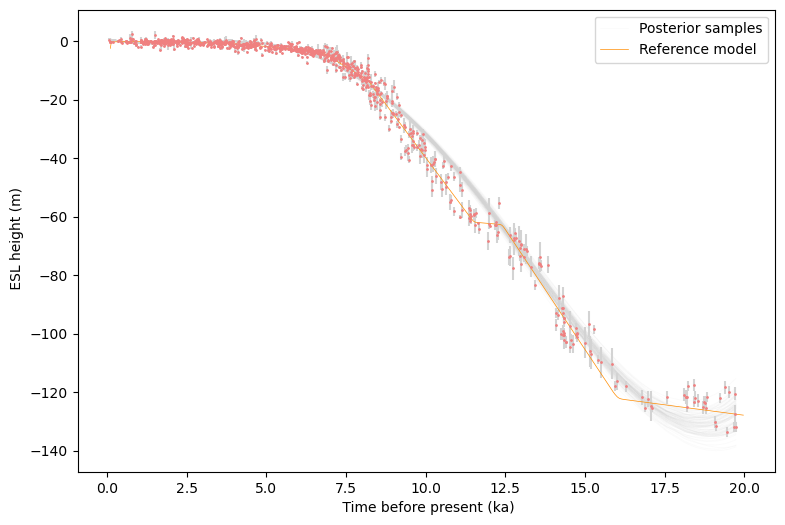

In [40]:
#@title Solution

m_lower_bound = np.array([-1.0,-10,-10,-10])             # lower bound for uniform prior
m_upper_bound = np.array([1.0,10,10,10])                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]")
plot_data()
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x, ref_y, "Reference model", color="darkorange")

Is there much change to the posterior distribution?

---

## Watermark

In [41]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev25
numpy 1.21.6
scipy 1.10.1
matplotlib 3.7.1
emcee 3.1.4
arviz 0.15.1
